# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import ray
import gc
import cv2
import time
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import xarray as xr
import matplotlib.gridspec as gridspec

from tqdm.notebook import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import medfilt
from pathlib import Path
from scipy.stats import binned_statistic
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

import torch
import torch.nn as nn
from kornia.geometry.transform import Affine
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from Utils.utils import *
import Utils.io_dict_to_hdf5 as ioh5
from Utils.format_data import *
from Utils.plotting import *
from main.models import *
from main.fit_GLM import *



# Load/Save All Data

In [2]:
pparams={
    'mod_titles':   ['Mot','Vis','Add','Mul','HF','VisNoShifter'],
    'mod_clrs':     ["#f1c40f","#06d6a0","#118ab2","#ef476f","#073b4c"],
    'dates_all':    ['070921/J553RT','101521/J559NC','102821/J570LT','110421/J569LT'],
}
pparams['date_ani2'] = [pparams['dates_all'][n].replace('/','_') for n in range(len(pparams['dates_all']))]


In [ ]:
##### Find Shuffle data files #####
params['do_shuffle']=True
params['complex']     = False
params['nt_glm_lag']=1
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT']#,'122021/J581RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
Shuff_List = []
for date_ani in dates_all:
    date_ani_dir = params['save_dir'].parent.parent.parent/date_ani
    params = get_modeltype(params)
    model_type = '_'.join(params['model_type'].split('_')[2:])
    mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_shuffled_best'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    Shuff_List.append(sorted([path for path in date_ani_dir.rglob(mod_name+'.h5') if ((('CropInputs' in path.parts) | ('complex' in path.parts)) &('VisNoShifter' not in path.stem) & ('SimRF' not in path.stem))]))
Shuff_List = np.stack(Shuff_List)
# Shuff_List

In [ ]:
##### Load data and find all files #####
Kfold = 0
args['free_move']=True
ModelList_all,test_std,tuning_sig_all,tuning_sig_all2,NCells_all,bad_cells_all,nsp_raw_all,hf_nsp_all,model_move_FM,model_move_HF,ax_lims_all,move_test_all,test_nsp_all = [], [], [],[], [], [], [], [], [], [], [], [], []

for d,date_ani in enumerate(pparams['dates_all']):
    args['free_move']   = True
    args['date_ani']    = date_ani
    args['NoL1']        = False
    args['NoL2']        = False
    args['reg_lap']     = False
    args['do_shuffle']  = False
    args['use_spdpup']  = False
    args['only_spdpup'] = False
    args['complex']     = False
    args['crop_input']  = True
    args['Nepochs']     = 10000
    params,_,_ = load_params(1,Kfold,args,debug=True)
    params['nt_glm_lag']=1
    date_ani_dir = params['save_dir'].parent.parent.parent/date_ani
    params = get_modeltype(params)
    model_type = '_'.join(params['model_type'].split('_')[2:])
    mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    # mod_name = '*{}_dt{:03d}_T*_NB{}_Kfold{:02d}_best'.format(model_type,int(params['model_dt']*1000), params['Nepochs'],Kfold)
    ModelList = np.array(sorted([path for path in date_ani_dir.rglob(mod_name+'.h5') if  (('CropInputs' in path.parts) |('EyeHead_only' in path.parts) | ('complex' in path.parts) | ('complex_onoff' in path.parts)| ('OnlySpdPupil' in path.parts))  & ('Laplace' not in path.stem) & ('VisShifter' not in path.stem)])) # (params['exp_name'] in path.as_posix()) &
    ModelList_all.append(ModelList)
    bad_cells = np.load(params['save_dir_hf']/'bad_cells.npy')
    bad_cells_all.append(bad_cells)
    params['use_spdpup']=True
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    model_move_FM.append(model_move)
    move_test_all.append(move_test)
    ax_lims_all.append(ax_ylims)
    nsp_raw_all.append(nsp_raw)
    test_nsp_all.append(data['test_nsp'])
    test_std.append(np.var(data['test_nsp'],axis=0))
    tuning_sig_all.append(tuning_sig)
    tuning_sig_all2.append(tuning_sig2)
    NCells_all.append(len(tuning_sig2))
    args['free_move'] = False
    params,_,_ = load_params(0,Kfold,args,debug=True)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    hf_nsp_all.append(data['test_nsp'])
    model_move_HF.append(model_move)

ModelList_all = np.stack(ModelList_all)
test_std=np.hstack(test_std)
ModelList_all = np.concatenate((ModelList_all,Shuff_List),axis=1)

In [ ]:
##### Save all data into nested dictionary #####
sf=4
params['nt_glm_lag']=1
date_ani2 = [pparams['dates_all'][n].replace('/','_') for n in range(len(pparams['dates_all']))]
All_data = {date_ani2[n]:{'complex':{},'CropInputs':{},'complex_onoff':{},'EyeHead_only':{}, 'complex_SpdPup':{},'CropInputs_SpdPup':{},'OnlySpdPupil':{}, } for n in range(len(date_ani2))}
for da, date_ani in enumerate(date_ani2):
    All_data[date_ani]['model_move_FM'] = model_move_FM[da]
    All_data[date_ani]['tuning_sig'] = tuning_sig_all[da]
    All_data[date_ani]['model_move_FM'] = model_move_FM[da]
    All_data[date_ani]['model_move_HF'] = model_move_HF[da]
    All_data[date_ani]['move_test'] = move_test_all[da]
    All_data[date_ani]['nsp_raw'] = nsp_raw_all[da]
    All_data[date_ani]['ax_lims'] = ax_lims_all[da]
    All_data[date_ani]['actual_meanfr'] = np.mean(test_nsp_all[da],axis=0)/params['model_dt']
    All_data[date_ani]['actual_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=test_nsp_all[da])[params['bin_length']:-params['bin_length']]
    All_data[date_ani]['actual_HF_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=hf_nsp_all[da])[params['bin_length']:-params['bin_length']]
    for _,fmod in enumerate(ModelList_all[da]):
        if 'hf1_wn' in fmod.parts:
            ModelRun = 4
        else: 
            mtype = fmod.name.split('_')[2]
            ModelRun = [n for n,m in enumerate(pparams['mod_titles']) if m == mtype][0]
        if ('complex_onoff' in fmod.parts):
            exp_type = 'complex_onoff'
        elif ('EyeHead_only' in fmod.parts):
            exp_type = 'EyeHead_only'
        elif ('complex' in fmod.parts):
            exp_type = 'complex'
        elif ('CropInputs' in fmod.parts):
            exp_type = 'CropInputs'
        elif ('OnlySpdPupil' in fmod.parts):
            exp_type = 'OnlySpdPupil' 
        if 'SpdPup' == fmod.name.split('_')[3]:
            exp_type = exp_type + '_SpdPup'

        VisName = pparams['mod_titles'][1]
        ModelName = pparams['mod_titles'][ModelRun]
        if 'shuffled'==fmod.name.split('_')[-2]:
            ModelName = ModelName + '_shuffled'
            VisName = VisName + '_shuffled'

        if ('EyeOnly'==fmod.name.split('_')[3]):
            ModelName = ModelName + '_EyeOnly'
        elif ('HeadOnly'==fmod.name.split('_')[3]):
            ModelName = ModelName + '_HeadOnly'

        GLM_Data = ioh5.load(fmod)
        All_data[date_ani][exp_type][ModelName +'_pred_smooth'] = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=GLM_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
        All_data[date_ani][exp_type][ModelName +'_vloss_all'] = GLM_Data['vloss_trace_all'].copy()
        All_data[date_ani][exp_type][ModelName +'_vloss_trace'] = np.nanmean(GLM_Data['vloss_trace_all'][:,-10:],axis=1)/np.nanvar(test_nsp_all[da],axis=0)
        if (ModelRun == 0):
            All_data[date_ani][exp_type][ModelName+'_moveW'] = GLM_Data['Cell_NN.0.weight'].copy()
        if (ModelRun == 1) | (ModelRun == 4) | (ModelRun == 5):
            All_data[date_ani][exp_type][ModelName+'_loss_regcv'] = GLM_Data['loss_regcv'].copy()
            if (exp_type =='complex')|(exp_type =='complex_SpdPup')|(exp_type =='complex_onoff'):
                RF_all = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0],2*params['nt_glm_lag'],)+params['nks'])
            else:
                RF_all = GLM_Data['Cell_NN.0.weight'].reshape((GLM_Data['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
            RF_all_up = np.zeros((RF_all.shape[:2] + ( sf*(RF_all.shape[-2]), sf*(RF_all.shape[-1]))))
            for celln in range(RF_all.shape[0]):
                for t in range(RF_all.shape[1]):
                    RF_all_up[celln,t] = cv2.resize(RF_all[celln,t], (sf*(RF_all.shape[-1]), sf*(RF_all.shape[-2])))
            All_data[date_ani][exp_type][ModelName+'_rf_up'] = RF_all_up
            All_data[date_ani][exp_type][ModelName+'_rf_all'] = RF_all
        if (ModelRun == 2) | (ModelRun==3):
            All_data[date_ani][exp_type][ModelName+'_moveW'] = GLM_Data['posNN.Layer0.weight'].copy()
            All_data[date_ani][exp_type][ModelName+'_moveBias'] = GLM_Data['posNN.Layer0.bias'].copy()
        if (ModelRun != 4):
            if 'shuffled'==fmod.name.split('_')[-2]:
                All_data[date_ani][exp_type][ModelName+'_cc_test'] = GLM_Data['cc_test'].copy()
                All_data[date_ani][exp_type][ModelName+'_r2_test'] = GLM_Data['r2_test'].copy()
            else:
                All_data[date_ani][exp_type][ModelName+'_cc_test'] = np.array([(np.corrcoef(All_data[date_ani][exp_type][ModelName+'_pred_smooth'][:,celln],All_data[date_ani]['actual_smooth'][:,celln])[0, 1]) for celln in range(All_data[date_ani]['actual_smooth'].shape[1])])
                All_data[date_ani][exp_type][ModelName+'_r2_test'] = np.array([(np.corrcoef(All_data[date_ani][exp_type][ModelName+'_pred_smooth'][:,celln],All_data[date_ani]['actual_smooth'][:,celln])[0, 1]**2) for celln in range(All_data[date_ani]['actual_smooth'].shape[1])])
        else: 
            if 'shuffled'==fmod.name.split('_')[-2]:
                All_data[date_ani][exp_type][ModelName+'_cc_test'] = GLM_Data['cc_test'].copy()
                All_data[date_ani][exp_type][ModelName+'_r2_test'] = GLM_Data['r2_test'].copy()
            else:
                All_data[date_ani][exp_type][ModelName+'_cc_test'] = np.array([(np.corrcoef(All_data[date_ani][exp_type][ModelName+'_pred_smooth'][:,celln],All_data[date_ani]['actual_HF_smooth'][:,celln])[0, 1]) for celln in range(All_data[date_ani]['actual_HF_smooth'].shape[1])])
                All_data[date_ani][exp_type][ModelName+'_r2_test'] = np.array([(np.corrcoef(All_data[date_ani][exp_type][ModelName+'_pred_smooth'][:,celln],All_data[date_ani]['actual_HF_smooth'][:,celln])[0, 1]**2) for celln in range(All_data[date_ani]['actual_HF_smooth'].shape[1])])
        if (ModelRun == 4):
            All_data[date_ani][exp_type]['HF_meanfr'] = np.mean(hf_nsp_all[da],axis=0)/params['model_dt']
            if exp_type == 'complex':
                r2_FMHF_RF_on = np.zeros(All_data[date_ani][exp_type][VisName+'_rf_all'].shape[0])
                r2_FMHF_RF_off = np.zeros(All_data[date_ani][exp_type][VisName+'_rf_all'].shape[0])
            else:
                r2_FMHF_RF = np.zeros(All_data[date_ani][exp_type][VisName+'_rf_all'].shape[0])
            for celln in np.arange(All_data[date_ani][exp_type][VisName+'_rf_all'].shape[0]):
                if exp_type == 'complex':
                    r2_FMHF_RF_on[celln] = np.corrcoef(All_data[date_ani][exp_type][VisName+'_rf_all'][celln,params['nt_glm_lag']//2].flatten(),All_data[date_ani][exp_type][ModelName+'_rf_all'][celln,(params['nt_glm_lag']//2)].flatten())[0,1]
                    r2_FMHF_RF_off[celln] = np.corrcoef(All_data[date_ani][exp_type][VisName+'_rf_all'][celln,(params['nt_glm_lag']//2 + params['nt_glm_lag'])].flatten(),All_data[date_ani][exp_type][ModelName+'_rf_all'][celln,(params['nt_glm_lag']//2 + params['nt_glm_lag'])].flatten())[0,1]
                else:
                    r2_FMHF_RF[celln] = np.corrcoef(All_data[date_ani][exp_type][VisName+'_rf_all'][celln,params['nt_glm_lag']//2].flatten(),All_data[date_ani][exp_type][ModelName+'_rf_all'][celln,params['nt_glm_lag']//2].flatten())[0,1]
            if exp_type == 'complex':
                All_data[date_ani][exp_type][ModelName+'_FMHF_on_cc'] = r2_FMHF_RF_on
                All_data[date_ani][exp_type][ModelName+'_FMHF_off_cc'] = r2_FMHF_RF_off
            else:
                All_data[date_ani][exp_type][ModelName+'_FMHF_cc'] = r2_FMHF_RF
            
SimRF_file = params['base_dir']/'121521/SimRF/fm1/SimRF_{}_dt{:03d}_T{:02d}_Model1_NB{}_Kfold{:02d}_best.h5'.format('withL1',int(params['model_dt']*1000), 1, params['Nepochs'],Kfold)
SimRFfit_file = params['base_dir']/'121521/SimRF/fm1/GLM_Network/MovModel1/version_0/SimRF/GLM_Pytorch_Vis_withL1_SimRF_dt050_T01_MovModel1_NB10000_Kfold00_best.h5'
SimFit_Data = ioh5.load(SimRFfit_file)
SimRF_Data = ioh5.load(SimRF_file)
RF_SimFit = SimFit_Data['Cell_NN.0.weight'].reshape((SimFit_Data['Cell_NN.0.weight'].shape[0],1,)+(30,40))
SimFit_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=1, arr=SimFit_Data['pred_cv'].copy())[:,params['bin_length']:-params['bin_length']].T
Sim_act_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=SimRF_Data['yte'].copy())[params['bin_length']:-params['bin_length']].T
Sim_r2 = np.array([(np.corrcoef(SimFit_smooth[:,celln],Sim_act_smooth[celln])[0, 1])**2 for celln in range(Sim_act_smooth.shape[0])])
Sim_cc = np.array([(np.corrcoef(SimFit_smooth[:,celln],Sim_act_smooth[celln])[0, 1]) for celln in range(Sim_act_smooth.shape[0])])
Sim_RFcc = np.array([(np.corrcoef(SimRF_Data['RF_actual'][celln].flatten(),RF_SimFit[celln,0].flatten())[0, 1]) for celln in range(Sim_act_smooth.shape[0])])
Sim_dict = {'SimData': {'Simfit_smooth': SimFit_smooth,
                        'Simact_smooth': Sim_act_smooth,
                        'Sim_r2': Sim_r2,
                        'Sim_cc': Sim_cc,
                        'Sim_RFcc': Sim_RFcc,
                        'Simact_RF':SimRF_Data['RF_actual'],
                        'Simfit_RF':RF_SimFit, 
                        'Sim_yte': SimRF_Data['yte'],}}
All_data.update(Sim_dict)

All_data['tuning_sig_all'] = tuning_sig_all

celltypes_all = pd.read_hdf(params['base_dir']/'Data4_dataset.h5')

da = 0
args['free_move']=True
args['date_ani'] = pparams['dates_all'][da]
params,_,_ = load_params(1,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')

# Remove files
# rm_list = list(params['base_dir'].parents[1].rglob('*onlySpdPup_SpdPup*.h5'))
# rm_list = np.array(sorted([path for path in params['base_dir'].parents[1].rglob('*T01*.h5') if  (('CropInputs' in path.parts) | ('complex' in path.parts) | ('OnlySpdPupil' in path.parts))  & ('VisShifter' not in path.stem) & ('complex_onoff' not in path.parts)])) # (params['exp_name'] in path.as_posix()) &
# for f in rm_list:
#     f.unlink()

In [ ]:
##### STA Data #####
sf=4
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
if args['free_move']:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #
exp_type = 'CropInputs'
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT']#,'122021/J581RT','020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
for da, date_ani in enumerate(dates_all):
    args['date_ani'] = dates_all[da]
    args['train_shifter']   = False
    args['NoL1']            = False
    args['NoL2']            = False
    args['reg_lap']         = False
    args['complex']         = False
    args['do_shuffle']      = False
    args['Nepochs']         = 10000
    params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)

    params = get_modeltype(params)
    model_type = '_'.join(params['model_type'].split('_')[2:])
    mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(model_type,int(params['model_dt']*1000), 5, params['Nepochs'],Kfold)
    ModelList = sorted(list(exp.save_dir.rglob(mod_name+'.h5')))
    args['train_shifter']   = False
    params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)
    # params['lag_list']     = [0]
    params['nt_glm_lag'] = len(params['lag_list'])
    if args['train_shifter']:
        params['lag_list']     = [0]
        params['nt_glm_lag']   = len(params['lag_list'])
        params['Nepochs']      = 5000
    data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)

    ##### Set Train Test Splits #####
    Kfold = 0
    train_idx = train_idx_list[Kfold]
    test_idx = test_idx_list[Kfold]
    data = load_Kfold_data(data,train_idx,test_idx,params)

    params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
    print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}, NoL1: {}, NoL2: {}, reg_lap: {}, complex: {}'.format(
        params['MovModel'],params['LinMix'],params['move_features'],params['Ncells'],params['train_shifter'],params['NoL1'],params['NoL2'],params['reg_lap'],params['complex']))
    
    xtr = xtr.cpu().detach().numpy()
    ytr = ytr.cpu().detach().numpy()
    xte = xte.cpu().detach().numpy()
    yte = yte.cpu().detach().numpy()
    sta = (xtr.T @ ytr)/np.sum(ytr,0,keepdims=True)
    yte_pred = xte@sta
    sta_im = sta.T.reshape((ytr.shape[1],params['nt_glm_lag'],)+params['nks'])
    sp_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=yte)[params['bin_length']:-params['bin_length']]
    pred_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=yte_pred)[params['bin_length']:-params['bin_length']]
    cc_all = np.array([(np.corrcoef(yte[:,celln],yte_pred[:,celln])[0, 1]) for celln in range(yte.shape[1])])

    # sta_im,sp_smooth,pred_smooth,cc_all = compute_STA(xtr,xte,ytr,yte,params)
    All_data[pparams['date_ani2'][da]][exp_type]['Vis_sta_im'] = sta_im
    RF_all_up = np.zeros((sta_im.shape[:2] + ( sf*(sta_im.shape[-2]), sf*(sta_im.shape[-1]))))
    for celln in range(sta_im.shape[0]):
        for t in range(sta_im.shape[1]):
            RF_all_up[celln,t] = cv2.resize(sta_im[celln,t], (sf*(sta_im.shape[-1]), sf*(sta_im.shape[-2])))
    All_data[pparams['date_ani2'][da]][exp_type]['Vis_sta_up'] = RF_all_up
    All_data[pparams['date_ani2'][da]][exp_type]['Vis_sta_sp_smooth'] = sp_smooth
    All_data[pparams['date_ani2'][da]][exp_type]['Vis_sta_pred_smooth'] = pred_smooth
    All_data[pparams['date_ani2'][da]][exp_type]['Vis_sta_cc_all'] = cc_all


In [ ]:
ioh5.save(params['save_dir'].parents[2]/'All_data_v2_T01.h5',All_data)

# Plotting

In [2]:
warnings.filterwarnings('ignore')
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
if args['free_move']:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #

dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT']#,'122021/J581RT','020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani']        = dates_all[0]
args['train_shifter']   = False
args['NoL1']            = False
args['NoL2']            = False
args['reg_lap']         = False
args['complex']         = False
args['do_shuffle']      = False
args['use_spdpup']      = False
args['Nepochs'] = 10000

params,file_dict,exp = load_params(MovModel,Kfold,args,{},debug=True)
params['lag_list']     = [-2,-1,-0,1,2]
params['nt_glm_lag']   = len(params['lag_list'])

pparams={
    'mod_titles':   ['Mot','Vis','Add','Mul','HF','VisNoShifter'],
    'mod_clrs':     ["#B541FF","#00A14B","#118ab2","#ef476f","#073b4c"],
    'dates_all':    ['070921/J553RT','101521/J559NC','102821/J570LT','110421/J569LT'],
}
pparams['date_ani2'] = [pparams['dates_all'][n].replace('/','_') for n in range(len(pparams['dates_all']))]
locals().update(pparams)

In [3]:
celltypes_all = pd.read_hdf(params['base_dir']/'Data4_dataset.h5')
All_data_T1 = ioh5.load(params['save_dir'].parents[2]/'All_data_v2_T01.h5')
All_data = ioh5.load(params['save_dir'].parents[2]/'All_data_v2.h5')
exp_type = 'CropInputs'


In [5]:
All_data[pparams['date_ani2'][0]].keys()

dict_keys(['5050split', 'CropInputs', 'CropInputs_SpdPup', 'EyeHead_only', 'OnlySpdPupil', 'actual_HF_smooth', 'actual_meanfr', 'actual_smooth', 'ax_lims', 'complex', 'complex_SpdPup', 'complex_onoff', 'model_move_FM', 'model_move_HF', 'move_test', 'nsp_raw', 'tuning_sig'])

In [5]:
All_data['070921_J553RT'].keys()

dict_keys(['5050split', 'CropInputs', 'CropInputs_SpdPup', 'EyeHead_only', 'OnlySpdPupil', 'actual_HF_smooth', 'actual_meanfr', 'actual_smooth', 'ax_lims', 'complex', 'complex_SpdPup', 'complex_onoff', 'model_move_FM', 'model_move_HF', 'move_test', 'nsp_raw', 'tuning_sig'])

# Figure 2

In [ ]:
exp_type = 'CropInputs'
vals_Vis = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test'] for da in range(len(pparams['dates_all']))])
vals_VisNoSh = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['VisNoShifter_cc_test'] for da in range(len(pparams['dates_all']))])
print('With Shifter:',np.nanmean(vals_Vis),'Without Shifter:', np.nanmean(vals_VisNoSh))

In [ ]:
fig2_name = paper_fig_dir/'Figure2.pdf'
# figure2(All_data,pparams)
figure2(All_data,pparams,figname=fig2_name)

# Figure 3

In [ ]:
fig3_name = paper_fig_dir/'Figure3.pdf'
# figure3(All_data,pparams)
figure3(All_data,pparams,figname=fig3_name)

# Figure 4

In [ ]:
figure4(All_data,pparams,exp_type='CropInputs')
# figure4(All_data,pparams,exp_type='OnlySpdPupil')
# figure4(All_data,pparams,exp_type='CropInputs_SpdPup')
# figure4(All_data,pparams,exp_type='complex_SpdPup')
# figure4(All_data,pparams,exp_type='complex_onoff')


In [ ]:
fig4_name = paper_fig_dir/'Figure4.pdf'
fig4_name_complex = paper_fig_dir/'Figure4_complex.pdf'
fig4_name_complex_onoff = paper_fig_dir/'Figure4_complex_onoff.pdf'
figure4(All_data,pparams,exp_type='CropInputs',figname=fig4_name)
# figure4(All_data,pparams,exp_type='complex',figname=fig4_name_complex)
# figure4(All_data,pparams,exp_type='complex_onoff',figname=fig4_name_complex_onoff)

In [ ]:
shuff_Vis = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_shuffled_cc_test'] for da in range(len(pparams['dates_all']))])
shuff_Add = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Add_shuffled_cc_test'] for da in range(len(pparams['dates_all']))])
shuff_Mul = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mul_shuffled_cc_test'] for da in range(len(pparams['dates_all']))])

## % stats 

In [ ]:
from scipy.stats import ttest_rel
from scipy.stats import ttest_1samp

### % time active

In [ ]:
da = 0
args['free_move']=True
args['do_shuffle']=False
active_all = []
for da in range(len(dates_all)):
    args['date_ani'] = dates_all[da]
    params,_,_ = load_params(2,Kfold,args,debug=True)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    active_all.append(np.sum(data['model_active']>.5)/data['model_active'].shape[0])

active_all = np.stack(active_all)

In [ ]:
for da in range(len(dates_all)):
    print('{} - % time active: {:.02}'.format(dates_all[da],active_all[da]))
print('{} - % time active: {:.02}'.format('mean',np.mean(active_all)))



### avg move speed

In [ ]:
da = 0
args['free_move']=True
args['do_shuffle']=False
args['use_spdpup'] = True
active_all = []
for da in range(len(dates_all)):
    args['date_ani'] = dates_all[da]
    args['do_norm'] = False
    params,_,_ = load_params(2,Kfold,args,debug=True)
    params['do_norm'] = False
    data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)
    active_all.append(np.mean(data['model_speed']))

for da in range(len(dates_all)):
    print('{} - avg Move speed: {:.02}'.format(dates_all[da],np.mean(active_all[da])))
print('{} - avg Move speed: {:.02}'.format('mean',np.mean(active_all)))

### Paired T test for Shifter on vs off

In [ ]:
#### across all cells
vals_Vis = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test'] for da in range(len(pparams['dates_all']))])
vals_VisNoSh = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['VisNoShifter_cc_test'] for da in range(len(pparams['dates_all']))])
r2_all = np.stack((vals_VisNoSh,vals_Vis))
vis_th = r2_all[1] > .05
ttest_rel(r2_all[0,vis_th],r2_all[1,vis_th])

In [ ]:
#### Average within session then t-test across sessions
vals_Vis=[]
vals_VisNoSh=[]
for da in range(len(pparams['dates_all'])):
    vals_Vis.append(np.nanmean(All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test']))
    vals_VisNoSh.append(np.nanmean(All_data[pparams['date_ani2'][da]][exp_type]['VisNoShifter_cc_test']))

vals_Vis=np.array(vals_Vis)
vals_VisNoSh=np.array(vals_VisNoSh)

ttest_rel(vals_Vis,vals_VisNoSh)

### Paired t-test GLM vs. STA

In [ ]:
cc_sta = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_sta_cc_all'] for da in range(len(pparams['dates_all']))])
vals_Vis = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test'] for da in range(len(pparams['dates_all']))])
cc_all2 = np.stack((cc_sta,vals_Vis))
RF_all = np.stack((np.vstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_sta_up'][:,0] for da in range(len(pparams['dates_all']))]),np.vstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_rf_up'][:,2,:,:] for da in range(len(pparams['dates_all']))])))

ttest_rel(vals_Vis,cc_sta)

### Standard Deviation of positional information

In [ ]:
np.round(np.nanstd(model_move_FM,axis=0),decimals=1),np.round(np.nanstd(model_move_HF,axis=0),decimals=1)

In [ ]:
np.sum(np.abs(model_move_FM[:,0])<15)/(model_move_FM.shape[0])

### number of units increased with joint fit

In [ ]:
vals_Mot = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mot_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Vis = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Add = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Add_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Mul = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mul_cc_test'] for da in range(len(pparams['dates_all']))])

np.sum(vals_Mot>vals_Vis),vals_Vis.shape[0],np.sum(vals_Mot<vals_Vis),vals_Vis.shape[0]

In [ ]:
np.mean(vals_Vis[vals_Vis>.05]), np.nanmean(vals_Vis), np.nanmax(vals_Vis)

In [ ]:
vals_Mot = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mot_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Vis = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Add = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Add_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Mul = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mul_cc_test'] for da in range(len(pparams['dates_all']))])
move_r2_th = (vals_Vis>.05) # & (vals_Mul>vals_Vis)
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]

In [ ]:
vals_joint = np.stack((vals_Add,vals_Mul))
vals_increased = np.max(vals_joint,axis=0)[np.any(vals_joint>vals_Vis,axis=0)]-vals_Vis[np.any(vals_joint>vals_Vis,axis=0)]
np.max(vals_joint,axis=0)[np.any(vals_joint>vals_Vis,axis=0)]-vals_Vis[np.any(vals_joint>vals_Vis,axis=0)]

T-test: Add vs Mul

In [ ]:
vals_Mot = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mot_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Vis = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Add = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Add_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Mul = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mul_cc_test'] for da in range(len(pparams['dates_all']))])
move_r2_th = ((vals_Add>vals_Vis) | (vals_Mul>vals_Vis)) # & (vals_Mul>vals_Vis)
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]
increase = vals_Vis
th1 = ((increase>0) & (vals_Vis>.22))

In [ ]:
ttest_rel(vals_Mul[th1],vals_Add[th1])

In [ ]:
## Paired t-test between mul and add and show the distributions are different. 

In [ ]:
avg_diff = []
avg_add=[]
avg_mul=[]
for da in range(len(pparams['dates_all'])):
    vM = All_data[pparams['date_ani2'][da]][exp_type]['Mul_cc_test']
    vV = All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test']
    vA = All_data[pparams['date_ani2'][da]][exp_type]['Add_cc_test']
    v_th = ((vA>vV) | (vM>vV)) & (vV>.05) # & (vals_Mul>vals_Vis)
    diff = vM[v_th]-vA[v_th]
    avg_add.append(np.nanmean(vA[v_th]))
    avg_mul.append(np.nanmean(vM[v_th]))
    avg_diff.append(np.nanmean(diff))
    print(np.nanmean(diff))
ttest_1samp(avg_diff,popmean=0)

In [ ]:
ttest_rel(vals_Add,vals_Mul),ttest_rel(avg_add,avg_mul)

In [ ]:
np.argmax(vals_Add[vals_Add<vals_Mul]),vals_Add[vals_Add<vals_Mul][np.argmax(vals_Add[vals_Add<vals_Mul])]

In [ ]:
np.nanargmax(vals_Add-vals_Mul),vals_Add[92],vals_Mul[92]

In [ ]:
np.where(vals_Add==vals_Add[vals_Add<vals_Mul][np.argmax(vals_Add[vals_Add<vals_Mul])])

# Supplementary Figures

## Load waveforms

In [ ]:
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT']#,'122021/J581RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['free_move']=True
scale_factor = 0.195 # multiply by raw trace to get microvolts
date_ani2 = [dates_all[n].replace('/','_') for n in range(len(dates_all))]
waveform_data = {date_ani2[n]:{} for n in range(len(date_ani2))}
for da in range(len(dates_all)):
    args['date_ani'] = dates_all[da]
    params,file_dict,_ = load_params(1,Kfold,args,debug=True)
    waveform_FM = ioh5.load(params['save_dir_fm']/'waveforms.h5')
    waveform_HF = ioh5.load(params['save_dir_hf']/'waveforms.h5')
    waveform_data[date_ani2[da]]['waveform_FM'] = waveform_FM
    waveform_data[date_ani2[da]]['waveform_HF'] = waveform_HF
    waveform_data[date_ani2[da]]['mean_wf_FM']  = scale_factor*np.stack([np.mean(waveform_FM['waveform']['{}'.format(n)],axis=0) for n in range(len(waveform_FM['waveform']))])
    waveform_data[date_ani2[da]]['std_wf_FM']   = scale_factor*np.stack([np.std(waveform_FM['waveform']['{}'.format(n)],axis=0) for n in range(len(waveform_FM['waveform']))])
    waveform_data[date_ani2[da]]['mean_wf_HF']  = scale_factor*np.stack([np.mean(waveform_HF['waveform']['{}'.format(n)],axis=0) for n in range(len(waveform_HF['waveform']))])
    waveform_data[date_ani2[da]]['std_wf_HF']   = scale_factor*np.stack([np.std(waveform_HF['waveform']['{}'.format(n)],axis=0) for n in range(len(waveform_HF['waveform']))])


In [ ]:
from sklearn.metrics import r2_score

celln = 1
samp_rate = 30000
mean_wf_FM = np.concatenate([waveform_data[date_ani2[da]]['mean_wf_FM']  for da in range(len(pparams['dates_all']))],axis=0)
std_wf_FM = np.concatenate([waveform_data[date_ani2[da]]['std_wf_FM']  for da in range(len(pparams['dates_all']))],axis=0)
mean_wf_HF = np.concatenate([waveform_data[date_ani2[da]]['mean_wf_HF']  for da in range(len(pparams['dates_all']))],axis=0)
std_wf_HF = np.concatenate([waveform_data[date_ani2[da]]['std_wf_HF']  for da in range(len(pparams['dates_all']))],axis=0)

time_waveform = np.arange(0,2,1000/samp_rate)
# fig, axs = plt.subplots(2,2,figsize=(8,3))

fig = plt.figure(constrained_layout=False, figsize=(10,6))
gs0 = gridspec.GridSpec(nrows=2,ncols=2, figure=fig, wspace=.3,hspace=.4)

# gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0,1:],wspace=.8,hspace=.7)
# gs01 = gridspec.GridSpecFromSubplotSpec(3,1, subplot_spec=gs0[0:,:1],wspace=.05,hspace=.8)
axs = np.array([fig.add_subplot(gs0[0,0]),fig.add_subplot(gs0[1,0])])

ax = axs[0]
ax.plot(time_waveform,mean_wf_FM[celln], 'k',label='waveform start')
ax.fill_between(time_waveform,mean_wf_FM[celln]+std_wf_FM[celln],mean_wf_FM[celln]-std_wf_FM[celln],color='k',alpha=.5)
ax.set_xlabel('time (ms)',fontsize=fontsize)
ax.set_title('Freely moving',fontsize=fontsize+2)
# ax.legend(labelcolor='linecolor', fontsize=fontsize, handlelength=0, handletextpad=0,loc='lower right',ncol=1)
ax.set_ylim([-150,100])
ax.set_ylabel(r'$\mu V$',fontsize=fontsize)

ax = axs[1]
ax.plot(time_waveform,mean_wf_HF[celln], 'k',label='waveform start')
ax.fill_between(time_waveform,mean_wf_HF[celln]+std_wf_HF[celln],mean_wf_HF[celln]-std_wf_HF[celln],color='k',alpha=.5)
ax.set_xlabel('time (ms)',fontsize=fontsize)
ax.set_title('Head-fixed',fontsize=fontsize+2)
ax.set_ylim([-150,100])
ax.set_ylabel(r'$\mu V$',fontsize=fontsize)


axs = np.array([fig.add_subplot(gs0[:1,1:]),fig.add_subplot(gs0[1:,1:])])
ax = axs[0]
std_wf_all = np.stack([std_wf_FM,std_wf_HF])
ax.bar(np.arange(2), np.mean(std_wf_all,axis=(1,2)),yerr= np.std(std_wf_all,axis=(1,2))/np.sqrt(std_wf_all.shape[0]), color='k',error_kw=dict(ecolor='#6D6E71', lw=2, capsize=5, capthick=2))
ax.set_xticks(np.arange(2))
ax.set_xticklabels(['Freely moving','Head-fixed'],fontsize=fontsize)
ax.set_ylabel(r'standard deviation ($\mu V$)', fontsize=fontsize)
ax.set_yticks([0,10,20,30])


ax = axs[1]
r2 = r2_score(mean_wf_FM.T,mean_wf_HF.T,multioutput='raw_values')
hbins=.01
lim0 = .8
lim1 = 1.01
dlim = .2
ylim = .4
dylim = .15
xticks = [.8,.9,1] 
count,edges = np.histogram(r2,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(r2),color='k',width=hbins, alpha=1,zorder=1) 


ax.set_xlabel('waveform $R^2$',fontsize=fontsize)
ax.set_ylabel('fraction of units',fontsize=fontsize)
ax.set_yticks(np.arange(0,ylim,dylim))
ax.set_yticklabels(np.round(np.arange(0,ylim,dylim),decimals=3),fontsize=fontsize)
ax.set_xticks(xticks)
ax.set_xticklabels(np.round(xticks,decimals=1), fontsize=fontsize)
plt.tight_layout()
fig.savefig(paper_fig_dir/'Waveform.pdf', dpi=300, transparent=True, bbox_inches='tight')


## Celltype Info

In [ ]:
from scipy.stats import ttest_rel

In [ ]:
exp_type = 'CropInputs'
vals_Mot = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mot_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Vis = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Add = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Add_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Mul = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mul_cc_test'] for da in range(len(pparams['dates_all']))])
vals_All = np.stack([vals_Mot,vals_Vis,vals_Mul-vals_Add])
fig, axs = plt.subplots(1,4,figsize=(8.5,1.8))
c_cell_EI   = celltypes_all['exc_or_inh'].factorize()[0]
vals_Mot2 = [vals_Mot[c_cell_EI==0],vals_Mot[c_cell_EI==1]]
vals_Vis2 = [vals_Vis[c_cell_EI==0],vals_Vis[c_cell_EI==1]]
ste_all = [(np.nanstd(vals_Mot2[0],axis=0)/np.sqrt(vals_Mot2[0].shape[0])),
            (np.nanstd(vals_Vis2[0],axis=0)/np.sqrt(vals_Vis2[0].shape[0])),
            (np.nanstd(vals_Mot2[1],axis=0)/np.sqrt(vals_Mot2[1].shape[0])),
            (np.nanstd(vals_Vis2[1],axis=0)/np.sqrt(vals_Vis2[1].shape[0]))]

ax = axs[0]
ax.bar([0],np.nanmean(vals_Mot2[0],axis=0),yerr=ste_all[0],color="#B541FF",error_kw=dict(ecolor='#6D6E71', lw=2, capsize=2, capthick=2))
ax.bar([1],np.nanmean(vals_Vis2[0],axis=0),yerr=ste_all[1],color="#00A14B",error_kw=dict(ecolor='#6D6E71', lw=2, capsize=2, capthick=2))
ax.bar([2],np.nanmean(vals_Mot2[1],axis=0),yerr=ste_all[2],color="#B541FF",error_kw=dict(ecolor='#6D6E71', lw=2, capsize=2, capthick=2))
ax.bar([3],np.nanmean(vals_Vis2[1],axis=0),yerr=ste_all[3],color="#00A14B",error_kw=dict(ecolor='#6D6E71', lw=2, capsize=2, capthick=2))
ax.plot([0,0, 1, 1], [.31, .32, .32, .31], linewidth=1, color='k')
ax.set_yticks([0,.15,.3])
ax.set_xticks([.5,2.5])
ax.set_xticklabels(['exc','inh'],fontsize=fontsize)
ax.set_ylabel('cc',fontsize=fontsize)
legend1 = ax.legend(['Vis','Pos'],labelcolor=["#00A14B","#B541FF"],fontsize=fontsize,ncol=1, markerscale=0, handlelength=0, handletextpad=-1.5,loc="upper left",frameon=False, bbox_to_anchor=(1.1, 1.1))



lims = (-.05, .85)
ticks = [0,.4,.8]
ln_max = .8
crange=500
c_cell_depth =celltypes_all['Wn_depth_from_layer5']#[move_r2_th]
labels = [r'$cc_{pos}$',r'$cc_{vis}$',r'$cc_{mul}-cc_{add}$']
for l,n in enumerate(range(1,3)):
    ax = axs[n]
    im=ax.scatter(c_cell_depth,vals_All[l],s=5,color='k',edgecolors='none')
    ax.set_xlabel(r'depth from L5 ($\mu$m)',fontsize=fontsize)
    ax.set_ylabel(labels[l], fontsize=fontsize)
    ax.set_xlim([-400,700])
    ax.set_xticks([-400,0,400])
    ax.set_xticklabels([-400,0,400])
    if l<2:
        ax.set_ylim([0,.7])
    else:
        ax.set_ylim(-.1,.1)

pparams['titles'] = [r'$\theta$',r'$\phi$',r'$\rho$',r'$\omega$']
MotW = np.vstack([All_data[pparams['date_ani2'][da]][exp_type]['Mot_moveW'] for da in range(len(pparams['dates_all']))])

x_sc = np.stack([np.random.normal(n, 0.1, MotW.shape[0]) for n in range(len(pparams['titles']))])
ax = axs[3]
for modeln in np.arange(0,len(pparams['titles'])):
    ax.scatter(x_sc[modeln], MotW[:,modeln],s=2,c='k',edgecolors='none')
ax.set_xticks(np.arange(len(pparams['titles'])))
ax.set_xticklabels(pparams['titles'],fontsize=fontsize)
ax.set_ylim([-.5,.5])
ax.set_yticks([-.5,0,.5])
ax.set_yticklabels([-.5,0,.5],fontsize=fontsize)
ax.set_ylabel('GLM Weights',fontsize=fontsize)
ax.axhline(y=0,ls='--',color='#6D6E71')

plt.tight_layout()
fig.savefig(paper_fig_dir/'CellType_Scatter.pdf', dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
exp_type = 'CropInputs'
All_data[pparams['date_ani2'][0]][exp_type]['Mot_moveW'].shape

In [ ]:
MotW = np.vstack([All_data[pparams['date_ani2'][da]][exp_type]['Mot_moveW'] for da in range(len(pparams['dates_all']))])
pparams['titles'] = [r'$(\theta)$',r'$(\phi)$',r'$(\rho)$',r'$(\omega)$']
x_sc = np.stack([np.random.normal(n, 0.1, MotW.shape[0]) for n in range(len(pparams['titles']))])
fig, axs = plt.subplots(figsize=(4,2))
ax = axs
for modeln in np.arange(0,len(pparams['titles'])):
    ax.scatter(x_sc[modeln], MotW[:,modeln],s=5,c='k',edgecolors='none')
ax.set_xticks(np.arange(len(pparams['titles'])))
ax.set_xticklabels(pparams['titles'],fontsize=fontsize)
ax.set_ylim([-.5,.5])
ax.set_yticks([-.5,0,.5])
ax.set_yticklabels([-.5,0,.5],fontsize=fontsize)
ax.set_ylabel('GLM Weights',fontsize=fontsize)
ax.axhline(y=0,ls='--',color='#6D6E71')
fig.savefig(paper_fig_dir/'PosW.jpg', dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
# ttest for excitatory cells 
ttest_rel(vals_Mot2[0],vals_Vis2[0]),ttest_rel(vals_Mot2[1],vals_Vis2[1])

## SpeedPup Comparisons

In [ ]:
exp_type = 'CropInputs'
vals_Add_CP = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Add_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Mul_CP = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mul_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Mot_CP = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mot_cc_test'] for da in range(len(pparams['dates_all']))])

exp_type = 'OnlySpdPupil'
vals_Add_OSP = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Add_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Mul_OSP = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mul_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Mot_OSP = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mot_cc_test'] for da in range(len(pparams['dates_all']))])

exp_type = 'CropInputs_SpdPup'
vals_Vis_SP = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Add_SP = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Add_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Mul_SP = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mul_cc_test'] for da in range(len(pparams['dates_all']))])

In [ ]:
exp_type = 'CropInputs_SpdPup'
vals_Mot = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mot_r2_test'] for da in range(len(pparams['dates_all']))])
vals_Vis = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_r2_test'] for da in range(len(pparams['dates_all']))])
vals_Add = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Add_r2_test'] for da in range(len(pparams['dates_all']))])
vals_Mul = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mul_r2_test'] for da in range(len(pparams['dates_all']))])

AddW = np.vstack([All_data[pparams['date_ani2'][da]][exp_type]['Add_moveW'] for da in range(len(pparams['dates_all']))])
MulW = np.vstack([All_data[pparams['date_ani2'][da]][exp_type]['Mul_moveW'] for da in range(len(pparams['dates_all']))])
MotW = np.vstack([All_data[pparams['date_ani2'][da]][exp_type]['Mot_moveW'] for da in range(len(pparams['dates_all']))])

Mot_thresh = vals_Mot>.05
vals_Add2 = (np.abs(AddW)/np.sum(np.abs(AddW),axis=1,keepdims=True))[Mot_thresh]
vals_Mul2 = (np.abs(MulW)/np.sum(np.abs(MulW),axis=1,keepdims=True))[Mot_thresh]
vals_Mot2 = (np.abs(MotW)/np.sum(np.abs(MotW),axis=1,keepdims=True))[Mot_thresh]

np.nanmean(vals_Add2,axis=0),np.nanmean(vals_Mul2,axis=0),np.nanmean(vals_Mot2,axis=0)

In [ ]:
vals_nonVis = (np.sum(np.abs(MulW)[:,:4],axis=1)[:,np.newaxis]/np.sum(np.abs(MulW),axis=1,keepdims=True))[Mot_thresh]
vals_nonVis2 = (np.sum(np.abs(MulW)[:,4:5],axis=1)[:,np.newaxis]/np.sum(np.abs(MulW),axis=1,keepdims=True))[Mot_thresh]
vals_nonVis3 = (np.sum(np.abs(MulW)[:,5:],axis=1)[:,np.newaxis]/np.sum(np.abs(MulW),axis=1,keepdims=True))[Mot_thresh]

In [ ]:
titles = ['theta','phi','pitch','roll','spd','pup']
r2_all = [np.nanmean(vals_Mot_CP)**2,np.nanmean(vals_Mot_OSP)**2,np.nanmean(vals_Vis_SP)**2,np.nanmean(vals_Mul_CP)**2,np.nanmean(vals_Mul_OSP)**2,np.nanmean(vals_Mul_SP)**2] #
fig, axs = plt.subplots(1,3,figsize=(8.4,2))
ax=axs[0]
ax.bar(np.arange(len(r2_all)),r2_all,color='k')
ax.set_xticks(np.arange(len(r2_all)))
ax.set_xticklabels(['pos','sp','vis','mul_pos','mul_sp','mul_all'],fontsize=fontsize,ha='center',rotation=45)
ax.set_yticks([0,.05,.1,.15])
ax.set_ylabel(r'$r^2$',fontsize=fontsize)

ax = axs[1]
for modeln in range(len(titles)):
    ax.bar(modeln, np.nanmean(vals_Mul2,axis=0)[modeln], color='k')
    ax.set_xticks(np.arange(0,len(titles)))
    ax.set_xticklabels(titles,fontsize=fontsize)
    ax.set_ylabel('Fraction of contribution',fontsize=fontsize)
    ax.set_title('Mul. Weights',fontsize=fontsize+2)
ax.set_yticks([0,.2,.4])

ax = axs[2]
ax.bar([0], np.nanmean(vals_nonVis,axis=0), color='k')
ax.bar([1], np.nanmean(vals_nonVis2,axis=0), color='k')
ax.bar([2], np.nanmean(vals_nonVis3,axis=0), color='k')
ax.set_xticks(np.arange(0,3))
ax.set_xticklabels(['position','speed','pupil'],fontsize=fontsize)
ax.set_ylabel('Fraction of contribution',fontsize=fontsize)
ax.set_title('Mul. Weights',fontsize=fontsize+2)
plt.tight_layout()
fig.savefig(paper_fig_dir/'Mul_SpdPup_Contribution.pdf', dpi=300, transparent=True, bbox_inches='tight')




In [ ]:
exp_type = 'CropInputs_SpdPup'
t = 0
dt = int(100/params['model_dt'])
# dt = 1000
cell = 265 # np.nanargmax(GLM_Data['cc_test'])
CellNum_Tot = get_cellnums(All_data,pparams,exp_type=exp_type)
da,celln = ([[da,np.where(CellNum_Tot[key]==cell)[0][0]] for da,key in enumerate(CellNum_Tot.keys()) if len(np.where(CellNum_Tot[key]==cell)[0])>0])[0]

titles = [r'$\theta$',r'$\phi$',r'$\rho$',r'$\omega$','speed','eyerad']
fig, axs = plt.subplots(1,3,figsize=(20,5))
ax = axs[0]
ax.plot(All_data[pparams['date_ani2'][da]]['actual_smooth'][t:t+dt,celln],label='data')
ax.plot(All_data[pparams['date_ani2'][da]][exp_type]['Vis_pred_smooth'][t:t+dt,celln],label='vis')
ax.plot(All_data[pparams['date_ani2'][da]][exp_type]['Add_pred_smooth'][t:t+dt,celln],label='add')
ax.plot(All_data[pparams['date_ani2'][da]][exp_type]['Mul_pred_smooth'][t:t+dt,celln],label='mul')
ax.legend(labelcolor='linecolor', fontsize=fontsize, handlelength=0, handletextpad=0,)

ax = axs[1]
ax.bar(titles,All_data[pparams['date_ani2'][da]][exp_type]['Add_moveW'][celln]+All_data[pparams['date_ani2'][da]][exp_type]['Add_moveBias'][celln])

ax = axs[2]
ax.bar(titles,All_data[pparams['date_ani2'][da]][exp_type]['Mul_moveW'][celln]+All_data[pparams['date_ani2'][da]][exp_type]['Mul_moveBias'][celln])

plt.suptitle('vis_cc: {:.03f}, add_cc: {:.03f}, mul_cc: {:.03f}'.format(All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test'][celln],All_data[pparams['date_ani2'][da]][exp_type]['Add_cc_test'][celln],All_data[pparams['date_ani2'][da]][exp_type]['Mul_cc_test'][celln]))



## Tuning half/half

In [ ]:
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT']#,'020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN', ,'122021/J581RT'
ModelList_all,test_std,tuning_sig_all,tuning_sig_all2,NCells_all,bad_cells_all,test_nsp_all,hf_nsp_all,model_move_FM,model_move_HF = [],[], [], [], [], [], [], [], [], []
for d,date_ani in enumerate(dates_all):
    args['free_move']   = True
    args['date_ani']    = date_ani
    args['NoL1']        = False
    args['NoL2']        = False
    args['reg_lap']     = False
    args['do_shuffle']  = False
    args['use_spdpup']  = False
    args['only_spdpup'] = False
    args['complex']     = False
    args['crop_input']  = True
    args['Nepochs']     = 10000
    params,_,_ = load_params(1,Kfold,args,debug=True)
    params['nt_glm_lag']=5
    date_ani_dir = params['save_dir'].parent.parent.parent/date_ani
    params = get_modeltype(params)
    model_type = '_'.join(params['model_type'].split('_')[2:])
    mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
    ModelList = np.array(sorted([path for path in date_ani_dir.rglob(mod_name+'.h5') if (params['exp_name'] in path.as_posix()) & ('SpdPup' not in path.stem) & ('VisNoShifter' not in path.stem) & ('SimRF' not in path.stem) & ('complex' not in path.stem)]))
    ModelList_all.append(ModelList)
    bad_cells = np.load(params['save_dir_hf']/'bad_cells.npy')
    bad_cells_all.append(bad_cells)
    data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
    tuning_thresh = .2
    thresh_fr = 1
    spk_percentile2 = np.arange(.125,1.125,.25)
    quartiles = np.arange(0,1.25,.25)

    nsp_half0 = data['model_nsp'][:data['model_nsp'].shape[0]//2]
    tuning_curves0 = np.zeros((nsp_half0.shape[1],model_move.shape[-1],len(quartiles)-1))
    tuning_stds0 = np.zeros((nsp_half0.shape[1],model_move.shape[-1],1))
    tuning_curve_edges0 = np.zeros((nsp_half0.shape[1],model_move.shape[-1],len(quartiles)-1))
    ax_ylims0 = np.zeros((nsp_half0.shape[-1],model_move.shape[-1]))

    nsp_half1 = data['model_nsp'][data['model_nsp'].shape[0]//2:]
    tuning_curves1 = np.zeros((nsp_half1.shape[1],model_move.shape[-1],len(quartiles)-1))
    tuning_stds1 = np.zeros((nsp_half1.shape[1],model_move.shape[-1],1))
    tuning_curve_edges1 = np.zeros((nsp_half1.shape[1],model_move.shape[-1],len(quartiles)-1))
    ax_ylims1 = np.zeros((nsp_half1.shape[-1],model_move.shape[-1]))
    for i,modeln in enumerate(range(model_move.shape[-1])):
        for celln in np.arange(nsp_half0.shape[1]):
            metric0 = model_move[:data['model_nsp'].shape[0]//2,modeln]
            nranges0 = np.quantile(metric0,quartiles)
            stat_range0, edges0, _ = binned_statistic(metric0,nsp_half0[:,celln],statistic='mean',bins=nranges0)
            stat_std0, _, _ = binned_statistic(metric0,nsp_half0[:,celln],statistic='std',bins=nranges0)
            tuning_curves0[celln,modeln] = stat_range0/params['model_dt']
            edge_mids0 = np.quantile(metric0,spk_percentile2)
            tuning_curve_edges0[celln,modeln] = edge_mids0
            tuning_stds0[celln,modeln] = stat_std0.max()

            metric1 = model_move[data['model_nsp'].shape[0]//2:,modeln]
            nranges1 = np.quantile(metric1,quartiles)
            stat_range1, edges1, _ = binned_statistic(metric1,nsp_half1[:,celln],statistic='mean',bins=nranges1)
            stat_std1, _, _ = binned_statistic(metric1,nsp_half1[:,celln],statistic='std',bins=nranges1)
            tuning_curves1[celln,modeln] = stat_range1/params['model_dt']
            edge_mids1 = np.quantile(metric1,spk_percentile2)
            tuning_curve_edges1[celln,modeln] = edge_mids1
            tuning_stds1[celln,modeln] = stat_std1.max()
        ax_ylims0[:,modeln] = np.nanmax(tuning_curves0[:,modeln],axis=-1)
        ax_ylims1[:,modeln] = np.nanmax(tuning_curves1[:,modeln],axis=-1)
    tc_mod0 = (np.max(tuning_curves0,axis=-1,keepdims=True)-np.min(tuning_curves0,axis=-1,keepdims=True))/(np.max(tuning_curves0,axis=-1,keepdims=True)+np.min(tuning_curves0,axis=-1,keepdims=True))
    avg_fr0 = np.mean(tuning_curves0,axis=(-1,-2)).squeeze()
    tc_mod1 = (np.max(tuning_curves1,axis=-1,keepdims=True)-np.min(tuning_curves1,axis=-1,keepdims=True))/(np.max(tuning_curves1,axis=-1,keepdims=True)+np.min(tuning_curves1,axis=-1,keepdims=True))
    avg_fr1 = np.mean(tuning_curves1,axis=(-1,-2)).squeeze()

    tuning_sig0 = tc_mod.copy()
    tuning_sig0[avg_fr0<thresh_fr,:,0] = np.nan
    tuning_sig20 = np.any(tuning_sig0>tuning_thresh,axis=1).squeeze()
    tuning_idx0 = np.where(tuning_sig20)[0]
    tuning_sig1 = tc_mod1.copy()
    tuning_sig1[avg_fr1<thresh_fr,:,0] = np.nan
    tuning_sig21 = np.any(tuning_sig1>tuning_thresh,axis=1).squeeze()
    tuning_idx1 = np.where(tuning_sig21)[0]
    tuning_sig = np.concatenate((tuning_sig0,tuning_sig1),axis=2)

    tuning_sig_all.append(tuning_sig)
tuning_sig_all = np.concatenate(tuning_sig_all,axis=0)

In [ ]:
titles = [r'$\theta$',r'$\phi$',r'$\rho$',r'$\omega$']

fig, axs = plt.subplots(1,4,figsize=(8.5,1.5))
for modeln in range(len(titles)):
    ax = axs[modeln]
    ax.scatter(tuning_sig_all[:,modeln,0],tuning_sig_all[:,modeln,1],s=5,c='k',edgecolors='none')
    ax.plot(np.linspace(0,1.05,100),np.linspace(0,1.05,100),c='k',lw=1,ls='--')
    ax.set_xticks([0,.5,1])
    ax.set_yticks([0,.5,1])
    ax.set_xlabel('first half',fontsize=fontsize)
    ax.set_ylabel('second half',fontsize=fontsize)
    ax.set_title(titles[modeln],fontsize=fontsize)
    ax.axis('square')
fig.savefig(paper_fig_dir/'5050_EyeHeadTuning.pdf', dpi=300, transparent=True, bbox_inches='tight')


## 5050 splits

In [ ]:
from sklearn.metrics import r2_score

args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
ModelList_5050 = []
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT']#,'122021/J581RT', '020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
for date_ani in dates_all:
    for is_fm in [False,True]:
        args['free_move'] = is_fm
        if args['free_move']:
            stim_type = 'fm1'
        else:
            stim_type = 'hf1_wn'  # 'fm1' #

        args['save_dir']         = '~/Research/SensoryMotorPred_Data/data4/'
        args['date_ani']         = date_ani
        args['train_shifter']    = False
        args['NoL1']             = False
        args['NoL2']             = False
        args['reg_lap']          = False
        args['complex']          = False
        args['complex_onoff']    = False
        args['do_shuffle']       = False
        args['shifter_5050']     = True
        args['shifter_5050_run'] = False
        args['Nepochs']          = 10000


        params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)
        params['nt_glm_lag']=5
        if args['train_shifter']:
            params['lag_list']     = [0]
            params['nt_glm_lag']   = len(params['lag_list'])
            params['Nepochs']      = 5000
        data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)
        params = get_modeltype(params)
        model_type = '_'.join(params['model_type'].split('_')[2:])
        mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best.h5'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
        ModelList = sorted(list(exp.save_dir.rglob(mod_name)))
        model_info = params['date_ani2']+'_'+mod_name.replace('*', '')
        ModelList_5050.append(ModelList)
##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
locals().update(data)


params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}, NoL1: {}, NoL2: {}, reg_lap: {}, complex: {}'.format(
    params['MovModel'],params['LinMix'],params['move_features'],params['Ncells'],params['train_shifter'],params['NoL1'],params['NoL2'],params['reg_lap'],params['complex']))
ModelList_5050 = np.stack(ModelList_5050).reshape(4,4)


In [ ]:
sf=4
params['nt_glm_lag']=5
date_ani2 = [dates_all[n].replace('/','_') for n in range(len(dates_all))]
split_5050 = {date_ani2[n]:{'5050split':{}} for n in range(len(date_ani2))}
for da, date_ani in enumerate(date_ani2):
    GLM_Data0_HF = ioh5.load(ModelList_5050[da,0])
    GLM_Data1_HF = ioh5.load(ModelList_5050[da,1])
    GLM_Data0_FM = ioh5.load(ModelList_5050[da,2])
    GLM_Data1_FM = ioh5.load(ModelList_5050[da,3])
    RF0_HF = GLM_Data0_HF['Cell_NN.0.weight'].reshape((GLM_Data0_HF['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
    RF1_HF = GLM_Data1_HF['Cell_NN.0.weight'].reshape((GLM_Data1_HF['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
    RF0_FM = GLM_Data0_FM['Cell_NN.0.weight'].reshape((GLM_Data0_FM['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
    RF1_FM = GLM_Data1_FM['Cell_NN.0.weight'].reshape((GLM_Data1_FM['Cell_NN.0.weight'].shape[0],params['nt_glm_lag'],)+params['nks'])
    RF_all_up0 = np.zeros(((2,) + RF0_HF.shape[:2] + ( sf*(RF0_HF.shape[-2]), sf*(RF0_HF.shape[-1]))))
    RF_all_up1 = np.zeros(((2,) + RF1_HF.shape[:2] + ( sf*(RF1_HF.shape[-2]), sf*(RF1_HF.shape[-1]))))

    for celln in range(RF0_HF.shape[0]):
        for t in range(RF0_HF.shape[1]):
            RF_all_up0[0,celln,t] = cv2.resize(RF0_HF[celln,t], (sf*(RF0_HF.shape[-1]), sf*(RF0_HF.shape[-2])))
            RF_all_up1[0,celln,t] = cv2.resize(RF1_HF[celln,t], (sf*(RF1_HF.shape[-1]), sf*(RF1_HF.shape[-2])))
            RF_all_up0[1,celln,t] = cv2.resize(RF0_FM[celln,t], (sf*(RF0_FM.shape[-1]), sf*(RF0_FM.shape[-2])))
            RF_all_up1[1,celln,t] = cv2.resize(RF1_FM[celln,t], (sf*(RF1_FM.shape[-1]), sf*(RF1_FM.shape[-2])))
    RF_CC_HF = np.zeros(RF0_HF.shape[0])
    RF_CC_FM = np.zeros(RF0_HF.shape[0])
    for celln in np.arange(RF0_HF.shape[0]):
        RF_CC_HF[celln] = np.corrcoef(RF0_HF[celln,2].flatten(),RF1_HF[celln,2].flatten())[0,1]
        RF_CC_FM[celln] = np.corrcoef(RF0_FM[celln,2].flatten(),RF1_FM[celln,2].flatten())[0,1]
    split_5050[date_ani]['5050split']['RF0_HF'] = RF0_HF
    split_5050[date_ani]['5050split']['RF1_HF'] = RF1_HF
    split_5050[date_ani]['5050split']['RF0_FM'] = RF0_FM
    split_5050[date_ani]['5050split']['RF1_FM'] = RF1_FM
    split_5050[date_ani]['5050split']['RF_all_up0'] = RF_all_up0
    split_5050[date_ani]['5050split']['RF_all_up1'] = RF_all_up1
    split_5050[date_ani]['5050split']['RF_CC_HF'] = RF_CC_HF
    split_5050[date_ani]['5050split']['RF_CC_FM'] = RF_CC_FM

In [ ]:
for da in range(len(pparams['date_ani2'])): 
    All_data[pparams['date_ani2'][da]]['5050split'] = split_5050[pparams['date_ani2'][da]]['5050split']

In [ ]:
exp_type = '5050split'
RF_CC_HF_all = np.hstack([split_5050[date_ani2[da]][exp_type]['RF_CC_HF'] for da in range(len(dates_all))])
RF_CC_FM_all = np.hstack([split_5050[date_ani2[da]][exp_type]['RF_CC_FM'] for da in range(len(dates_all))])
RF_all_up0 = np.concatenate([split_5050[date_ani2[da]][exp_type]['RF_all_up0'] for da in range(len(dates_all))],axis=1)
RF_all_up1 = np.concatenate([split_5050[date_ani2[da]][exp_type]['RF_all_up1'] for da in range(len(dates_all))],axis=1)
 

In [ ]:

thresh = .5
frac_HF = np.sum(RF_CC_HF_all>thresh)/RF_CC_HF_all.shape[0]
frac_FM = np.sum(RF_CC_FM_all>thresh)/RF_CC_FM_all.shape[0]
frac_both = np.sum(((RF_CC_HF_all>thresh)&(RF_CC_FM_all>thresh)))/RF_CC_HF_all.shape[0]

In [ ]:
fontsize=12
lag_list = [0,0] #params['lag_list']
# for da in tqdm(np.arange(len(date_ani2))):
da = 0
cells = [22,101,61]#[22,42,101] 

# fig1,axs = plt.subplots(len(cells),2*len(lag_list),figsize=(len(cells)*len(lag_list),1.5*len(cells)))
# axs = axs.reshape(len(cells),2*len(lag_list))
fig1 = plt.figure(constrained_layout=True, figsize=(8.2,4.25))
gs0 = fig1.add_gridspec(nrows=3, ncols=6, wspace=.8, hspace=.9)
gs00 = gridspec.GridSpecFromSubplotSpec(nrows=len(cells),ncols=2*len(lag_list), subplot_spec=gs0[:,:3], wspace=.05, hspace=.08)
axs = np.array([fig1.add_subplot(gs00[n,m]) for n in range(len(cells)) for m in range(2*len(lag_list))]).reshape(len(cells),2*len(lag_list))


for n, cell in enumerate(cells):
    for m,lag in enumerate(lag_list):
        if m == 0:
            crange0_HF = np.max(np.abs(RF_all_up0[0,cell,2]))
            crange0_FM = np.max(np.abs(RF_all_up0[1,cell,2]))
            ax = axs[n,m]
            im = ax.imshow(RF_all_up0[0,cell,2],'RdBu_r',vmin=-crange0_HF,vmax=crange0_HF)
            ax.set_title('RF cc={:.03f}'.format(RF_CC_HF_all[cell]),fontsize=fontsize)
            ax = axs[n,m+2]
            im = ax.imshow(RF_all_up0[1,cell,2],'RdBu_r',vmin=-crange0_FM,vmax=crange0_FM)
            ax.set_title('RF cc={:.03f}'.format(RF_CC_FM_all[cell]),fontsize=fontsize)
        else:
            crange1_HF = np.max(np.abs(RF_all_up1[0,cell,2]))
            crange1_FM = np.max(np.abs(RF_all_up1[1,cell,2]))
            ax = axs[n,m]
            im = ax.imshow(RF_all_up1[0,cell,2],'RdBu_r',vmin=-crange1_HF,vmax=crange1_HF)
            ax = axs[n,m+2]
            im = ax.imshow(RF_all_up1[1,cell,2],'RdBu_r',vmin=-crange1_FM,vmax=crange1_FM)
        # add_colorbar(im)
    axs[n,0].set_ylabel('unit {}'.format(n+1),fontsize=fontsize)
scalebar = AnchoredSizeBar(axs[0,0].transData,
                        20, '10 deg', 'lower left', 
                        pad=0.1,
                        color='black',
                        frameon=False,
                        size_vertical=1,
                        )
axs[0,0].add_artist(scalebar)
# scale1 = ScaleBar(dx=.5, width_fraction=.05,location='lower left',scale_formatter=lambda value, unit: f'{value} deg')
# axs[0,0].add_artist(scale1)

ext = []
for m in range(axs.shape[1]):
    ext.append([axs[0,m].get_window_extent().x0, axs[0,m].get_window_extent().width])

for ax in axs.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
# axs[0,0].set_title('First half',fontsize=fontsize+2)
# axs[0,1].set_title('Second half',fontsize=fontsize+2)
inv = fig1.transFigure.inverted()
width_left = ext[0][0]+(ext[1][0]+ext[1][1]-ext[0][0])/2.
left_center = inv.transform( (width_left, 1) )
width_right = ext[2][0]+(ext[3][0]+ext[3][1]-ext[2][0])/2.
right_center = inv.transform( (width_right, 1) )

# set column spanning title 
# the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
# plt.figtext(left_center[0],.99,'Head-fixed', va="center", ha="center", size=fontsize+2)
# plt.figtext(right_center[0],.99,'Freely moving', va="center", ha="center", size=fontsize+2)
plt.figtext(.12,.99,'Head-fixed', va="center", ha="center", size=fontsize+2)
plt.figtext(.34,.99,'Freely moving', va="center", ha="center", size=fontsize+2)

gs01 = gridspec.GridSpecFromSubplotSpec(nrows=2,ncols=1, subplot_spec=gs0[:,3:], wspace=.05, hspace=.08)
axs = np.array([fig1.add_subplot(gs01[0,0]),fig1.add_subplot(gs01[1,0])])


thresh = .5
frac_HF = np.sum(RF_CC_HF_all>thresh)/RF_CC_HF_all.shape[0]
frac_FM = np.sum(RF_CC_FM_all>thresh)/RF_CC_FM_all.shape[0]
frac_both = np.sum(((RF_CC_HF_all>thresh)&(RF_CC_FM_all>thresh)))/RF_CC_HF_all.shape[0]

hbins = .02
lim0 = -.1
lim1 = 1
dlim = .2
xlab = 'cc'
ax = axs[0]
count_HF,edges_HF = np.histogram(RF_CC_HF_all,bins=np.arange(lim0,lim1,hbins))
edges_mid_HF = np.array([(edges_HF[i]+edges_HF[i+1])/2 for i in range(len(edges_HF)-1)])
count_FM,edges_FM = np.histogram(RF_CC_FM_all,bins=np.arange(lim0,lim1,hbins))
edges_mid_FM = np.array([(edges_FM[i]+edges_FM[i+1])/2 for i in range(len(edges_FM)-1)])
ax.bar(edges_mid_HF, count_HF/len(RF_CC_HF_all),color='k',width=hbins, alpha=.75)
ax.bar(edges_mid_FM, count_FM/len(RF_CC_FM_all),color='r',width=hbins, alpha=.75)
ax.set_xticks([0,.25,.5,.75,1])
ax.set_xticklabels([0,.25,.5,.75,1],fontsize=fontsize-2)
ax.set_xlabel(xlab,fontsize=fontsize)
ax.axvline(x=np.nanmean(RF_CC_HF_all),lw=2, c='k',ls='--',zorder=1)
ax.axvline(x=np.nanmean(RF_CC_FM_all),lw=2, c='r',ls='--',zorder=1)
ax.set_ylabel('fraction of units',fontsize=fontsize)
ax.set_yticks([0,.03,.06])
ax.set_yticklabels([0,.03,.06],fontsize=fontsize-2)    
legend1 = ax.legend(['HF','FM'],labelcolor=['k','r'],fontsize=fontsize,ncol=2, markerscale=0, handlelength=0, handletextpad=-1.5,loc="upper left",frameon=False, bbox_to_anchor=(.1, 1.1))



ax = axs[1]
ax.bar([0,1,2], [frac_HF, frac_FM, frac_both],color='k')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['HF', 'FM', 'Both'],fontsize=fontsize)
ax.set_ylabel('fraction of neurons',fontsize=fontsize)
ax.set_yticks(np.arange(0,.81,.4))



plt.tight_layout()
# fig1.savefig(paper_fig_dir/('5050_RF_Comparison.pdf'), transparent=True, bbox_inches='tight',dpi=300)


In [ ]:
# Mean of HF and FM cc distributions
np.nanmean(RF_CC_HF_all),np.nanmean(RF_CC_FM_all)

In [ ]:
thresh = .5
frac_HF = np.sum(RF_CC_HF_all>thresh)/RF_CC_HF_all.shape[0]
frac_FM = np.sum(RF_CC_FM_all>thresh)/RF_CC_FM_all.shape[0]
frac_both = np.sum(((RF_CC_HF_all>thresh)&(RF_CC_FM_all>thresh)))/RF_CC_HF_all.shape[0]

fig, axs = plt.subplots(figsize=(2,2))
ax = axs
ax.bar([0,1,2], [frac_HF, frac_FM, frac_both],color='k')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['HF', 'FM', 'Both'],fontsize=fontsize)
ax.set_ylabel('fraction of neurons',fontsize=fontsize)
ax.set_yticks(np.arange(0,.81,.4))

fig1.savefig(paper_fig_dir/('fraction_significant.pdf'), transparent=True, bbox_inches='tight',dpi=300)


## Complex RFs

In [ ]:
all_hfFM_complex_lin =  np.hstack([All_data_T1[pparams['date_ani2'][da]]['complex']['HF_FMHF_on_cc'] for da in range(len(dates_all))])
all_hfFM_complex_nlin =  np.hstack([All_data_T1[pparams['date_ani2'][da]]['complex']['HF_FMHF_off_cc'] for da in range(len(dates_all))])
all_hfFM_simple =  np.hstack([All_data[pparams['date_ani2'][da]]['CropInputs']['HF_FMHF_cc'] for da in range(len(dates_all))])

In [ ]:
pdf_name = paper_fig_dir/ ('ComplexRFs_onoff_T01.pdf')
exp_type = 'complex'
FM_RF_all = np.concatenate([All_data[pparams['date_ani2'][da]][exp_type]['Vis_rf_all']  for da in range(len(pparams['dates_all']))],axis=0)
HF_RF_all = np.concatenate([All_data[pparams['date_ani2'][da]][exp_type]['HF_rf_all']  for da in range(len(pparams['dates_all']))],axis=0)
vals_Vis = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test'] for da in range(len(pparams['dates_all']))])
vals_HF = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['HF_cc_test'] for da in range(len(pparams['dates_all']))])
# cell = 101
params['nt_glm_lag'] = 1
lag_list = 2*[0] #2*[-100,-50,0,50,100] 
pdf = PdfPages(pdf_name)
# cell_list = [22,117,101,64]
for n, cell in enumerate(range(FM_RF_all.shape[0])):
# for n, cell in enumerate(tqdm(cell_list)):#range(FM_RF_all.shape[0]))):
    fig, axs = plt.subplots(2,params['nt_glm_lag']*2,figsize=(2*params['nt_glm_lag'],2))
    for m in range(2*params['nt_glm_lag']):
        crange2 = np.max(np.abs(FM_RF_all[cell])) 
        ax = axs[0,m]
        im2 = ax.imshow(FM_RF_all[cell, m],'RdBu_r', vmin=-crange2, vmax=crange2)
        ax.set_title('{} ms'.format(lag_list[m]),fontsize=fontsize)
        crange1 = np.max(np.abs(HF_RF_all[cell])) 
        ax = axs[1,m]
        im1 = ax.imshow(HF_RF_all[cell, m], 'RdBu_r', vmin=-crange1, vmax=crange1) 
        ax.set_title('{} ms'.format(lag_list[m]),fontsize=fontsize)
        if m == 9:
            cbar2 = add_colorbar(im2)
            cbar1 = add_colorbar(im1)
            cbar2.outline.set_linewidth(1)
            cbar1.outline.set_linewidth(1)


    plt.suptitle('unit: {} FMcc={:.03f} HFcc={:.03f} '.format(cell,vals_Vis[cell],vals_HF[cell]), fontsize=fontsize).set_multialignment('center')
    
    axs[1,0].set_ylabel('head- \n fixed', fontsize=fontsize)
    axs[0,0].set_ylabel('freely \n moving', fontsize=fontsize)

    for ax in axs.flat:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(0.5)
            ax.spines[axis].set_visible(True)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])   

    plt.tight_layout()
    pdf.savefig()
    plt.close()

pdf.close()


### Complex 5050 Splits

In [ ]:
from sklearn.metrics import r2_score

args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
ModelList_5050 = []
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT']#,'122021/J581RT', '020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
for date_ani in dates_all:
    for is_fm in [False,True]:
        args['free_move'] = is_fm
        if args['free_move']:
            stim_type = 'fm1'
        else:
            stim_type = 'hf1_wn'  # 'fm1' #

        args['save_dir']         = '~/Research/SensoryMotorPred_Data/data4/'
        args['date_ani']         = date_ani
        args['train_shifter']    = False
        args['NoL1']             = False
        args['NoL2']             = False
        args['reg_lap']          = False
        args['complex']          = False
        args['complex_onoff']    = True
        args['do_shuffle']       = False
        args['shifter_5050']     = True
        args['shifter_5050_run'] = False
        args['Nepochs']          = 10000


        params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)
        params['nt_glm_lag']=1
        if args['train_shifter']:
            params['lag_list']     = [0]
            params['nt_glm_lag']   = len(params['lag_list'])
            params['Nepochs']      = 5000
        data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)
        params = get_modeltype(params)
        model_type = '_'.join(params['model_type'].split('_')[2:])
        mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best.h5'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
        ModelList = sorted(list(exp.save_dir.rglob(mod_name)))
        model_info = params['date_ani2']+'_'+mod_name.replace('*', '')
        ModelList_5050.append(ModelList)
##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
locals().update(data)


params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}, NoL1: {}, NoL2: {}, reg_lap: {}, complex: {}'.format(
    params['MovModel'],params['LinMix'],params['move_features'],params['Ncells'],params['train_shifter'],params['NoL1'],params['NoL2'],params['reg_lap'],params['complex']))
ModelList_5050 = np.stack(ModelList_5050).reshape(4,4)


In [ ]:
sf=4
params['nt_glm_lag']=1
date_ani2 = [dates_all[n].replace('/','_') for n in range(len(dates_all))]
split_5050 = {date_ani2[n]:{'5050split':{}} for n in range(len(date_ani2))}
for da, date_ani in enumerate(date_ani2):
    GLM_Data0_HF = ioh5.load(ModelList_5050[da,0])
    GLM_Data1_HF = ioh5.load(ModelList_5050[da,1])
    GLM_Data0_FM = ioh5.load(ModelList_5050[da,2])
    GLM_Data1_FM = ioh5.load(ModelList_5050[da,3])
    RF0_HF = GLM_Data0_HF['Cell_NN.0.weight'].reshape((GLM_Data0_HF['Cell_NN.0.weight'].shape[0],2*params['nt_glm_lag'],)+params['nks'])
    RF1_HF = GLM_Data1_HF['Cell_NN.0.weight'].reshape((GLM_Data1_HF['Cell_NN.0.weight'].shape[0],2*params['nt_glm_lag'],)+params['nks'])
    RF0_FM = GLM_Data0_FM['Cell_NN.0.weight'].reshape((GLM_Data0_FM['Cell_NN.0.weight'].shape[0],2*params['nt_glm_lag'],)+params['nks'])
    RF1_FM = GLM_Data1_FM['Cell_NN.0.weight'].reshape((GLM_Data1_FM['Cell_NN.0.weight'].shape[0],2*params['nt_glm_lag'],)+params['nks'])
    RF_HF = np.concatenate(([RF0_HF[:,:1],RF1_HF[:,:1],RF0_HF[:,1:],RF1_HF[:,1:]]),axis=1)
    RF_FM = np.concatenate(([RF0_FM[:,:1],RF1_FM[:,:1],RF0_FM[:,1:],RF1_FM[:,1:]]),axis=1)
    RF_all_up = np.zeros(((2,) + RF_HF.shape[:2] + ( sf*(RF_HF.shape[-2]), sf*(RF_HF.shape[-1]))))
    for celln in range(RF_FM.shape[0]):
        for t in range(RF_FM.shape[1]):
            RF_all_up[0,celln,t] = cv2.resize(RF_HF[celln,t], (sf*(RF_HF.shape[-1]), sf*(RF_HF.shape[-2])))
            RF_all_up[1,celln,t] = cv2.resize(RF_FM[celln,t], (sf*(RF_FM.shape[-1]), sf*(RF_FM.shape[-2])))

    RF_CC_HF = np.zeros((RF0_HF.shape[0]))
    RF_CC_FM = np.zeros((RF0_HF.shape[0]))
    
    for celln in np.arange(RF0_HF.shape[0]):
        RF_CC_HF[celln] = np.corrcoef(RF0_HF[celln].flatten(),RF1_HF[celln].flatten())[0,1]
        RF_CC_FM[celln] = np.corrcoef(RF0_FM[celln].flatten(),RF1_FM[celln].flatten())[0,1]
        # RF_CC_HF[celln,1] = np.corrcoef(RF0_HF[celln,1].flatten(),RF1_HF[celln,1].flatten())[0,1]
        # RF_CC_FM[celln,0] = np.corrcoef(RF0_FM[celln,0].flatten(),RF1_FM[celln,0].flatten())[0,1]
    split_5050[date_ani]['5050split']['RF_HF'] = RF_HF
    split_5050[date_ani]['5050split']['RF_FM'] = RF_FM
    split_5050[date_ani]['5050split']['RF_CC_HF'] = RF_CC_HF
    split_5050[date_ani]['5050split']['RF_CC_FM'] = RF_CC_FM
    split_5050[date_ani]['5050split']['RF_all_up'] = RF_all_up


In [ ]:
exp_type = '5050split'
RF_CC_HF_all = np.hstack([All_data_T1[date_ani2[da]][exp_type]['RF_CC_HF'] for da in range(len(dates_all))])
RF_CC_FM_all = np.hstack([All_data_T1[date_ani2[da]][exp_type]['RF_CC_FM'] for da in range(len(dates_all))])
RF_all_up = np.concatenate([All_data_T1[date_ani2[da]][exp_type]['RF_all_up'] for da in range(len(dates_all))],axis=1)


thresh = .5
frac_HF = np.sum(RF_CC_HF_all>thresh,axis=0)/RF_CC_HF_all.shape[0]
frac_FM = np.sum(RF_CC_FM_all>thresh,axis=0)/RF_CC_FM_all.shape[0]
frac_both = np.sum(((RF_CC_HF_all>thresh)&(RF_CC_FM_all>thresh)),axis=0)/RF_CC_HF_all.shape[0]

In [ ]:
from scipy import stats
lag_list = RF_all_up.shape[2]# [0,0] #params['lag_list']
# for da in tqdm(np.arange(len(date_ani2))):
da = 0
cells = [247,3,41]#,101,61]# ,101,61]#[22,42,101] 

# fig1,axs = plt.subplots(len(cells),2*len(lag_list),figsize=(len(cells)*len(lag_list),1.5*len(cells)))
# axs = axs.reshape(len(cells),2*len(lag_list))
fig1 = plt.figure(constrained_layout=False, figsize=(12,6))
gs0 = fig1.add_gridspec(nrows=3, ncols=9, wspace=2.5, hspace=.9)
gs00 = gridspec.GridSpecFromSubplotSpec(nrows=2*len(cells),ncols=lag_list, subplot_spec=gs0[:,:3], wspace=.05, hspace=.08)
axs = np.array([fig1.add_subplot(gs00[n,m]) for n in range(2*len(cells)) for m in range(lag_list)]).reshape((2*len(cells)//2),2,lag_list)

HF_FM = ['HF','FM']
on_off = ['L0','L1','NL0','NL1']
for n, cell in enumerate(cells):
    for j, cond in enumerate(HF_FM):
        for m,lag in enumerate(range(lag_list)):
            crange0_HF = np.max(np.abs(RF_all_up[j,cell]))
            ax = axs[n,j,m]
            im = ax.imshow(RF_all_up[j,cell,m],'RdBu_r',vmin=-crange0_HF,vmax=crange0_HF)
            ax.set_title(on_off[m],fontsize=fontsize)


        axs[n,j,0].set_ylabel('{}'.format(HF_FM[j]),fontsize=fontsize)

scalebar = AnchoredSizeBar(axs[0,0,0].transData,
                        20, '10 deg', 'lower left', 
                        pad=0.1,
                        color='black',
                        frameon=False,
                        size_vertical=1,
                        )
axs[0,0,0].add_artist(scalebar)

ext = []
for m in range(axs.shape[1]):
    ext.append([axs[0,0,m].get_window_extent().x0, axs[0,0,m].get_window_extent().width])

for ax in axs.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

gs01 = gridspec.GridSpecFromSubplotSpec(nrows=2,ncols=1, subplot_spec=gs0[:,3:6], wspace=.05, hspace=.4)
axs = np.array([fig1.add_subplot(gs01[0,0]),fig1.add_subplot(gs01[1,0])])


thresh = .5
frac_HF = np.sum(RF_CC_HF_all>thresh,axis=0)/RF_CC_HF_all.shape[0]
frac_FM = np.sum(RF_CC_FM_all>thresh,axis=0)/RF_CC_FM_all.shape[0]
frac_both = np.sum(((RF_CC_HF_all>thresh)&(RF_CC_FM_all>thresh)),axis=0)/RF_CC_HF_all.shape[0]

hbins = .05
lim0 = -.1
lim1 = 1
dlim = .2
xlab = 'cc'
ax = axs[0]
count_HF,edges_HF = np.histogram(RF_CC_HF_all,bins=np.arange(lim0,lim1,hbins))
edges_mid_HF = np.array([(edges_HF[i]+edges_HF[i+1])/2 for i in range(len(edges_HF)-1)])
count_FM,edges_FM = np.histogram(RF_CC_FM_all,bins=np.arange(lim0,lim1,hbins))
edges_mid_FM = np.array([(edges_FM[i]+edges_FM[i+1])/2 for i in range(len(edges_FM)-1)])
ax.bar(edges_mid_HF, count_HF/len(RF_CC_HF_all),color='k',width=hbins, alpha=.75)
ax.bar(edges_mid_FM, count_FM/len(RF_CC_FM_all),color='r',width=hbins, alpha=.75)

# ax.set_xticks([0,.25,.5,.75,1])
# ax.set_xticklabels([0,.25,.5,.75,1],fontsize=fontsize-2)
ax.set_xlabel(xlab,fontsize=fontsize)
ax.axvline(x=np.nanmean(RF_CC_HF_all),lw=2, c='k',ls='--',zorder=1)
ax.axvline(x=np.nanmean(RF_CC_FM_all),lw=2, c='r',ls='--',zorder=1)
ax.set_ylabel('fraction of units',fontsize=fontsize)
# ax.set_yticks([0,.03,.06])
# ax.set_yticklabels([0,.03,.06],fontsize=fontsize-2)    
legend1 = ax.legend(['HF','FM'],labelcolor=['k','r'],fontsize=fontsize,ncol=2, markerscale=0, handlelength=0, handletextpad=-1.5,loc="upper left",frameon=False, bbox_to_anchor=(.1, 1.1))



ax = axs[1]
ax.bar(np.arange(3),np.stack([frac_HF, frac_FM, frac_both]),color='k')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['HF', 'FM', 'Both'],fontsize=fontsize)
ax.set_ylabel('fraction of neurons',fontsize=fontsize)
ax.set_yticks(np.arange(0,.81,.4))


thresh=.5
exp_type = '5050split'
RF_CC_HF_all_c = np.hstack([All_data_T1[date_ani2[da]][exp_type]['RF_CC_HF'] for da in range(len(dates_all))])
RF_CC_FM_all_c = np.hstack([All_data_T1[date_ani2[da]][exp_type]['RF_CC_FM'] for da in range(len(dates_all))])
RF_CC_HF_all_s = np.hstack([All_data[pparams['date_ani2'][da]]['5050split']['RF_CC_HF'] for da in range(len(pparams['dates_all']))])
RF_CC_FM_all_s = np.hstack([All_data[pparams['date_ani2'][da]]['5050split']['RF_CC_FM'] for da in range(len(pparams['dates_all']))])
all_hfFM_complex_lin =  np.hstack([All_data_T1[pparams['date_ani2'][da]]['complex']['HF_FMHF_on_cc'] for da in range(len(dates_all))])
all_hfFM_complex_nlin =  np.hstack([All_data_T1[pparams['date_ani2'][da]]['complex']['HF_FMHF_off_cc'] for da in range(len(dates_all))])
all_hfFM_simple =  np.hstack([All_data[pparams['date_ani2'][da]]['CropInputs']['HF_FMHF_cc'] for da in range(len(dates_all))])

gs02 = gridspec.GridSpecFromSubplotSpec(nrows=2,ncols=1, subplot_spec=gs0[:,6:], wspace=.05, hspace=.4)
axs = np.array([fig1.add_subplot(gs02[0,0]),fig1.add_subplot(gs02[1,0])])
ax = axs[0]
lim0=-.5
lim1=.75
hbins=.05
thresh_complex = ((RF_CC_HF_all_c>thresh)&(RF_CC_FM_all_c>thresh))
thresh_simple = ((RF_CC_HF_all_s>thresh)&(RF_CC_FM_all_s>thresh))
count_S,edges_S = np.histogram(all_hfFM_simple[thresh_simple],bins=np.arange(lim0,lim1,hbins))
edges_mid_S = np.array([(edges_S[i]+edges_S[i+1])/2 for i in range(len(edges_S)-1)])
count_CL,edges_CL = np.histogram(all_hfFM_complex_lin[thresh_complex],bins=np.arange(lim0,lim1,hbins))
edges_mid_CL = np.array([(edges_CL[i]+edges_CL[i+1])/2 for i in range(len(edges_CL)-1)])
count_CNL,edges_CNL = np.histogram(all_hfFM_complex_nlin[thresh_complex],bins=np.arange(lim0,lim1,hbins))
edges_mid_CNL = np.array([(edges_CNL[i]+edges_CNL[i+1])/2 for i in range(len(edges_CNL)-1)])
ax.bar(edges_mid_S, count_S/len(all_hfFM_simple[thresh_simple]),color='k',width=hbins, alpha=.75,label='Simple')
ax.bar(edges_mid_CL, count_CL/len(all_hfFM_complex_lin[thresh_complex]),color='r',width=hbins, alpha=.75,label='Complex Lin')
ax.bar(edges_mid_CNL, count_CNL/len(all_hfFM_complex_nlin[thresh_complex]),color='b',width=hbins, alpha=.75,label='Complex NLin')

ax.axvline(np.nanmean(all_hfFM_simple[thresh_simple]),ls='--',color='k')
ax.axvline(np.nanmean(all_hfFM_complex_lin[thresh_complex]),ls='--',color='r')
ax.axvline(np.nanmean(all_hfFM_complex_nlin[thresh_complex]),ls='--',color='b')
ax.set_xlabel('HF_FM cc',fontsize=fontsize)
ax.legend(frameon=False,fontsize=fontsize,loc='upper right',labelcolor='linecolor', handlelength=0, handletextpad=0,bbox_to_anchor=(1.2, 1))

plt.tight_layout()
# fig1.savefig(paper_fig_dir/('5050_RF_Comparison_Complex.jpg'), transparent=True, bbox_inches='tight',dpi=300)


In [ ]:
np.where(all_hfFM_complex_nlin>.2)

In [ ]:
exp_type = '5050split'
RF_CC_HF_all_c = np.hstack([split_5050[date_ani2[da]][exp_type]['RF_CC_HF'] for da in range(len(dates_all))])
RF_CC_FM_all_c = np.hstack([split_5050[date_ani2[da]][exp_type]['RF_CC_FM'] for da in range(len(dates_all))])
RF_all_up = np.concatenate([split_5050[date_ani2[da]][exp_type]['RF_all_up'] for da in range(len(dates_all))],axis=1)

RF_CC_HF_all_s = np.hstack([All_data[pparams['date_ani2'][da]]['5050split']['RF_CC_HF'] for da in range(len(pparams['dates_all']))])
RF_CC_FM_all_s = np.hstack([All_data[pparams['date_ani2'][da]]['5050split']['RF_CC_FM'] for da in range(len(pparams['dates_all']))])
thresh=.5
thresh_simple = ((RF_CC_HF_all_s>thresh)&(RF_CC_FM_all_s>thresh))

In [ ]:
exp_type = 'complex'
thresh=.5
thresh_complex = ((RF_CC_HF_all_c>thresh)&(RF_CC_FM_all_c>thresh))
thresh_simple = ((RF_CC_HF_all_s>thresh)&(RF_CC_FM_all_s>thresh))
all_hfFM_complex_lin =  np.hstack([All_data_T1[pparams['date_ani2'][da]]['complex']['HF_FMHF_on_cc'] for da in range(len(dates_all))])
all_hfFM_complex_nlin =  np.hstack([All_data_T1[pparams['date_ani2'][da]]['complex']['HF_FMHF_off_cc'] for da in range(len(dates_all))])
all_hfFM_simple =  np.hstack([All_data[pparams['date_ani2'][da]]['CropInputs']['HF_FMHF_cc'] for da in range(len(dates_all))])

fig, axs = plt.subplots()
ax = axs
ax.hist(all_hfFM_simple[thresh_simple],bins=20,color='k',alpha=.75,label='Simple')
ax.hist(all_hfFM_complex_lin[thresh_complex],bins=20,color='r',alpha=.75,label='Complex Lin')
ax.hist(all_hfFM_complex_nlin[thresh_complex],bins=20,color='b',alpha=.75,label='Complex NLin')
ax.axvline(np.nanmean(all_hfFM_simple[thresh_simple]),ls='--',color='k')
ax.axvline(np.nanmean(all_hfFM_complex_lin[thresh_complex]),ls='--',color='r')
ax.axvline(np.nanmean(all_hfFM_complex_nlin[thresh_complex]),ls='--',color='b')
ax.set_xlabel('HF_FM cc',fontsize=fontsize)
ax.legend(frameon=False,fontsize=fontsize)
fig.savefig(paper_fig_dir/('HF_FM_CC_with_TRT.jpg'), transparent=True, bbox_inches='tight',dpi=300)
print('simple:',np.nanmean(all_hfFM_simple[thresh_simple]),'complex lin:',np.nanmean(all_hfFM_complex_lin[thresh_complex]),'complex Nlin:',np.nanmean(all_hfFM_complex_nlin[thresh_complex]))


### Complex Reviewer Fig

In [ ]:
# RF_CC_HF_all = np.hstack([All_data[date_ani2[da]][exp_type]['RF_CC_HF'] for da in range(len(dates_all))])
# RF_CC_FM_all = np.hstack([All_data[date_ani2[da]][exp_type]['RF_CC_FM'] for da in range(len(dates_all))])
exp_type='CropInputs'
Vis_RF_all_up_simp = np.concatenate([All_data_T1[date_ani2[da]][exp_type]['Vis_rf_up'] for da in range(len(dates_all))],axis=0)
HF_RF_all_up_simp = np.concatenate([All_data_T1[date_ani2[da]][exp_type]['HF_rf_up'] for da in range(len(dates_all))],axis=0)
exp_type = 'complex_onoff'
Vis_RF_all_up_comp = np.concatenate([All_data_T1[date_ani2[da]][exp_type]['Vis_rf_up'] for da in range(len(dates_all))],axis=0)
HF_RF_all_up_comp = np.concatenate([All_data_T1[date_ani2[da]][exp_type]['HF_rf_up'] for da in range(len(dates_all))],axis=0)
Vis_RF_all_up =  np.concatenate((Vis_RF_all_up_simp,Vis_RF_all_up_comp),axis=1)
HF_RF_all_up =  np.concatenate((HF_RF_all_up_simp,HF_RF_all_up_comp),axis=1)
RF_all_up = np.stack((HF_RF_all_up,Vis_RF_all_up))

In [ ]:
RF_all_up.shape

In [ ]:
All_data[pparams['date_ani2'][da]]['complex_onoff'].keys()

In [ ]:
lag_list = 3
da = 0
cells = [247,3,41]#,101,61]# ,101,61]#[22,42,101] 


fig1 = plt.figure(constrained_layout=False, figsize=(8,6))
gs0 = fig1.add_gridspec(nrows=3, ncols=6, wspace=2.5, hspace=.5)
gs00 = gridspec.GridSpecFromSubplotSpec(nrows=2*len(cells),ncols=lag_list, subplot_spec=gs0[:,:3], wspace=.1, hspace=.02)
axs = np.array([fig1.add_subplot(gs00[n,m]) for n in range(2*len(cells)) for m in range(lag_list)]).reshape((2*len(cells)),lag_list)

HF_FM = ['HF','FM']
# on_off = ['Lin Only','C_lin','C_Nlin']
on_off = ['Lin Only','C_On','C_Off']
n = 0
for _, cell in enumerate(cells):
    for m,lag in enumerate(range(lag_list)):
        if m == 0:
            crange0_HF = np.max(np.abs(RF_all_up[0,cell,m]))
            crange0_FM = np.max(np.abs(RF_all_up[1,cell,m]))
        else: 
            crange0_HF = np.max(np.abs(RF_all_up[0,cell,1:]))
            crange0_FM = np.max(np.abs(RF_all_up[1,cell,1:]))
        ax = axs[n,m]
        im = ax.imshow(RF_all_up[0,cell,m],'RdBu_r',vmin=-crange0_HF,vmax=crange0_HF)
        ax.set_title(on_off[m],fontsize=fontsize)
        axs[n,0].set_ylabel('{}'.format(HF_FM[n%2]),fontsize=fontsize)
        crange0_HF = np.max(np.abs(RF_all_up[1,cell]))
        ax = axs[n+1,m]
        im = ax.imshow(RF_all_up[1,cell,m],'RdBu_r',vmin=-crange0_FM,vmax=crange0_FM)
        axs[n+1,0].set_ylabel('{}'.format(HF_FM[(n+1)%2]),fontsize=fontsize)
    n = n+2

scalebar = AnchoredSizeBar(axs[0,0].transData,
                        20, '10 deg', 'lower left', 
                        pad=0.1,
                        color='black',
                        frameon=False,
                        size_vertical=1,
                        )
axs[0,0].add_artist(scalebar)

ext = []
for m in range(axs.shape[1]):
    ext.append([axs[0,m].get_window_extent().x0, axs[0,m].get_window_extent().width])

for ax in axs.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])



gs02 = gridspec.GridSpecFromSubplotSpec(nrows=1,ncols=1, subplot_spec=gs0[:1,3:], wspace=.05, hspace=.4)
axs = np.array([fig1.add_subplot(gs02[0,0])])

thresh=.5
exp_type = '5050split'
RF_CC_HF_all_c = np.hstack([split_5050[date_ani2[da]][exp_type]['RF_CC_HF'] for da in range(len(dates_all))])
RF_CC_FM_all_c = np.hstack([split_5050[date_ani2[da]][exp_type]['RF_CC_FM'] for da in range(len(dates_all))])
RF_all_up = np.concatenate([split_5050[date_ani2[da]][exp_type]['RF_all_up'] for da in range(len(dates_all))],axis=1)

RF_CC_HF_all_s = np.hstack([All_data[pparams['date_ani2'][da]]['5050split']['RF_CC_HF'] for da in range(len(pparams['dates_all']))])
RF_CC_FM_all_s = np.hstack([All_data[pparams['date_ani2'][da]]['5050split']['RF_CC_FM'] for da in range(len(pparams['dates_all']))])
thresh_complex = ((RF_CC_HF_all_c>thresh)&(RF_CC_FM_all_c>thresh))
thresh_simple = ((RF_CC_HF_all_s>thresh)&(RF_CC_FM_all_s>thresh))
# all_hfFM_complex_lin =  np.hstack([All_data_T1[pparams['date_ani2'][da]]['complex_onoff']['HF_FMHF_on_cc'] for da in range(len(dates_all))])
# all_hfFM_complex_nlin =  np.hstack([All_data_T1[pparams['date_ani2'][da]]['complex_onoff']['HF_FMHF_off_cc'] for da in range(len(dates_all))])
all_hfFM_complex_onoff =  np.hstack([All_data_T1[pparams['date_ani2'][da]]['complex_onoff']['HF_FMHF_cc'] for da in range(len(dates_all))])
all_hfFM_simple =  np.hstack([All_data[pparams['date_ani2'][da]]['CropInputs']['HF_FMHF_cc'] for da in range(len(dates_all))])

ax = axs[0]
lim0=-.5
lim1=.75
hbins=.1
thresh_complex = ((RF_CC_HF_all_c>thresh)&(RF_CC_FM_all_c>thresh))
thresh_simple = ((RF_CC_HF_all_s>thresh)&(RF_CC_FM_all_s>thresh))
count_S,edges_S = np.histogram(all_hfFM_simple[thresh_simple],bins=np.arange(lim0,lim1,hbins))
edges_mid_S = np.array([(edges_S[i]+edges_S[i+1])/2 for i in range(len(edges_S)-1)])
# count_CL,edges_CL = np.histogram(all_hfFM_complex_lin[thresh_complex],bins=np.arange(lim0,lim1,hbins))
# edges_mid_CL = np.array([(edges_CL[i]+edges_CL[i+1])/2 for i in range(len(edges_CL)-1)])
# count_CNL,edges_CNL = np.histogram(all_hfFM_complex_nlin[thresh_complex],bins=np.arange(lim0,lim1,hbins))
# edges_mid_CNL = np.array([(edges_CNL[i]+edges_CNL[i+1])/2 for i in range(len(edges_CNL)-1)])
count_CNL,edges_CNL = np.histogram(all_hfFM_complex_onoff[thresh_complex],bins=np.arange(lim0,lim1,hbins))
edges_mid_CNL = np.array([(edges_CNL[i]+edges_CNL[i+1])/2 for i in range(len(edges_CNL)-1)])
ax.bar(edges_mid_S, count_S/len(all_hfFM_simple[thresh_simple]),color='k',width=hbins, alpha=.75,label='Simple')
# ax.bar(edges_mid_CL, count_CL/len(all_hfFM_complex_lin[thresh_complex]),color='r',width=hbins, alpha=.75,label='Complex Lin')
ax.bar(edges_mid_CNL, count_CNL/len(all_hfFM_complex_onoff[thresh_complex]),color='r',width=hbins, alpha=.75,label='Complex NLin')

ax.axvline(np.nanmean(all_hfFM_simple[thresh_simple]),ls='--',color='k')
# ax.axvline(np.nanmean(all_hfFM_complex_lin[thresh_complex]),ls='--',color='r')
ax.axvline(np.nanmean(all_hfFM_complex_onoff[thresh_complex]),ls='--',color='#6D0000')
ax.set_xlabel('HF_FM cc',fontsize=fontsize)
ax.legend(frameon=False,fontsize=fontsize,loc='upper right',labelcolor='linecolor', handlelength=0, handletextpad=0,bbox_to_anchor=(1.2, 1))
ax.set_ylabel('fraction of units',fontsize=fontsize)

cells = [101,61]
gs00 = gridspec.GridSpecFromSubplotSpec(nrows=2*len(cells),ncols=lag_list, subplot_spec=gs0[1:,3:], wspace=.1, hspace=.02)
axs = np.array([fig1.add_subplot(gs00[n,m]) for n in range(2*len(cells)) for m in range(lag_list)]).reshape((2*len(cells)),lag_list)

exp_type='CropInputs'
Vis_RF_all_up_simp = np.concatenate([All_data_T1[date_ani2[da]][exp_type]['Vis_rf_up'] for da in range(len(dates_all))],axis=0)
HF_RF_all_up_simp = np.concatenate([All_data_T1[date_ani2[da]][exp_type]['HF_rf_up'] for da in range(len(dates_all))],axis=0)
exp_type = 'complex_onoff'
Vis_RF_all_up_comp = np.concatenate([All_data_T1[date_ani2[da]][exp_type]['Vis_rf_up'] for da in range(len(dates_all))],axis=0)
HF_RF_all_up_comp = np.concatenate([All_data_T1[date_ani2[da]][exp_type]['HF_rf_up'] for da in range(len(dates_all))],axis=0)
Vis_RF_all_up =  np.concatenate((Vis_RF_all_up_simp,Vis_RF_all_up_comp),axis=1)
HF_RF_all_up =  np.concatenate((HF_RF_all_up_simp,HF_RF_all_up_comp),axis=1)
RF_all_up = np.stack((HF_RF_all_up,Vis_RF_all_up))

HF_FM = ['HF','FM']
n = 0
for _, cell in enumerate(cells):
    for m,lag in enumerate(range(lag_list)):
        if m == 0:
            crange0_HF = np.max(np.abs(RF_all_up[0,cell,m]))
            crange0_FM = np.max(np.abs(RF_all_up[1,cell,m]))
        else: 
            crange0_HF = np.max(np.abs(RF_all_up[0,cell,1:]))
            crange0_FM = np.max(np.abs(RF_all_up[1,cell,1:]))
        ax = axs[n,m]
        im = ax.imshow(RF_all_up[0,cell,m],'RdBu_r',vmin=-crange0_HF,vmax=crange0_HF)
        ax.set_title(on_off[m],fontsize=fontsize)
        axs[n,0].set_ylabel('{}'.format(HF_FM[n%2]),fontsize=fontsize)
        crange0_HF = np.max(np.abs(RF_all_up[1,cell]))
        ax = axs[n+1,m]
        im = ax.imshow(RF_all_up[1,cell,m],'RdBu_r',vmin=-crange0_FM,vmax=crange0_FM)
        axs[n+1,0].set_ylabel('{}'.format(HF_FM[(n+1)%2]),fontsize=fontsize)
    n = n+2


ext = []
for m in range(axs.shape[1]):
    ext.append([axs[0,m].get_window_extent().x0, axs[0,m].get_window_extent().width])

for ax in axs.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

fig1.savefig(paper_fig_dir/('Reviewer_ComplexOnOff_Fig.pdf'), transparent=True, bbox_inches='tight',dpi=300)


In [ ]:
All_data_T1[pparams['data_ani2'][0]]['CropInputs'].keys()

## Darkness Data

In [ ]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
args['fm_dark'] = False
if args['free_move']:
    stim_type = 'fm1'
elif args['fm_dark']:
    stim_type = 'fm1_dark'
else:
    stim_type = 'hf1_wn'  # 'fm1' #

dates_all = ['100821/J559TT', '101621/J559NC', '102721/J558NC', '110421/J558LT','110521/J569LT']
args['data_dir'] = '~/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/'
args['save_dir'] = '~/Research/SensoryMotorPred_Data/data2/'
args['date_ani'] = dates_all[0]
args['train_shifter']=True
args['NoL1'] = False
args['NoL2'] = False
args['complex'] = False
args['reg_lap'] = False
args['do_shuffle']=False
args['Nepochs'] = 10000


params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)

data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)
params = get_modeltype(params)
model_type = '_'.join(params['model_type'].split('_')[2:])
mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
ModelList = sorted(list(exp.save_dir.rglob(mod_name+'.h5')))
model_info = params['date_ani2']+'_'+mod_name.replace('*', '')

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
locals().update(data)


params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, output_size, meanbias, model_move = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, LinMix: {}, move_features: {}, Ncells: {}, train_shifter: {}, NoL1: {}, NoL2: {}, reg_lap: {}, comples: {}'.format(
    params['MovModel'],params['LinMix'],params['move_features'],params['Ncells'],params['train_shifter'],params['NoL1'],params['NoL2'],params['reg_lap'],params['complex']))

In [ ]:
# celltype_dir = params['data_dir'].parent.parent.parent.parent / 'batch_files/120221_hffm'
# celltype_file = celltype_dir / 'pooled_ephys_population_update_120621.pickle'
# celltype = pickle.load(open(celltype_file,'rb'))

Kfold = 0
args['free_move']=True
mod_titles = ['pos','vis','add','mul','HF']
mod_clrs = ["#f1c40f","#06d6a0","#118ab2","#ef476f","#073b4c"]
dates_all =  ['100821/J559TT', '101621/J559NC', '102721/J558NC', '110421/J558LT','110521/J569LT']
ModelList_all,test_std,tuning_sig_all,tuning_sig_all2,NCells_all,bad_cells_all,test_nsp_all,hf_nsp_all,model_move_FM,model_move_HF = [],[], [], [], [], [], [], [], [], []
for d,date_ani in enumerate(dates_all):
    tuning_sig1,tuning_sig2a,NCells1,bad_cells1,test_nsp1,model_move1= [], [], [], [], [], [],
    for fm_dark in [False,True]:
        args['date_ani']    = date_ani
        args['data_dir'] = '~/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/'
        args['free_move']   = True
        args['fm_dark']     = fm_dark
        if args['free_move'] :
            if args['fm_dark']:
                stim_type   = 'fm1_dark'
            else:
                stim_type   = 'fm1'
        else:
            stim_type       = 'hf1_wn'
        args['NoL1']        = False
        args['NoL2']        = False
        args['reg_lap']     = False
        args['complex']     = False
        args['do_shuffle']  = False
        args['Nepochs']     = 10000
        params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)
        params['nt_glm_lag']=5
        params['thresh_cells']=0
        date_ani_dir = params['save_dir'].parent.parent.parent/date_ani
        params = get_modeltype(params)
        model_type = '_'.join(params['model_type'].split('_')[2:])
        mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
        # ModelList = np.array(sorted([path for path in date_ani_dir.rglob(mod_name+'.h5') if ('RevisionSims' in path.as_posix()) &('VisNoShifter' not in path.stem) & ('SimRF' not in path.stem)]))
        # ModelList_all.append(ModelList)
        bad_cells = np.load(params['save_dir_hf']/'bad_cells.npy')
        data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
        bad_cells1.append(bad_cells)
        # model_move1.append(model_move)
        tuning_sig1.append(tuning_sig)
        tuning_sig2a.append(tuning_sig2)
        print(stim_type,mod_name)
    bad_cells_all.append(np.stack(bad_cells1))
    # model_move_FM.append(np.stack(model_move1))
    test_nsp_all.append(data['test_nsp'])
    test_std.append(np.var(data['test_nsp'],axis=0))
    tuning_sig_all.append(np.stack(tuning_sig1))
    tuning_sig_all2.append(np.stack(tuning_sig2a))
    NCells_all.append(len(tuning_sig2a))

# ModelList_all = np.stack(ModelList_all)
test_std=np.hstack(test_std)
tuning_sig_all2 = np.hstack(tuning_sig_all2)
tuning_sig_all = np.concatenate(tuning_sig_all,axis=1)
# model_move_FM = np.concatenate(model_move_FM,axis=0)
# model_move_HF = np.concatenate(model_move_HF,axis=0)

ModelList_all

In [ ]:
##### Modulation Index Histograms #####
dwidth = .02
# fig,axs = plt.subplots(2,len(titles),figsize=(8,4))
fig = plt.figure(constrained_layout=False, figsize=(12,6))
gs0 = gridspec.GridSpec(nrows=1, ncols=5, figure=fig,wspace=.3,hspace=.8)
gs00 = gridspec.GridSpecFromSubplotSpec(nrows=3, ncols=4, subplot_spec=gs0[0,:-1],wspace=.8,hspace=.7)
# gs00 = gridspec.GridSpecFromSubplotSpec(nrows=2, ncols=4, subplot_spec=gs0[0,:-1],wspace=.8,hspace=.7)
axs1 = np.array([fig.add_subplot(gs00[n,m]) for n in range(3) for m in range(4) ]).reshape(3,4)
for dk in [0,1]:
    for modeln in np.arange(0,len(titles)):
        ax = axs1[dk,modeln]
        count,edges = np.histogram(tuning_sig_all[dk,:,modeln], bins=np.arange(0,1.1,dwidth))
        edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
        ax.bar(edges_mid, count/len(tuning_sig_all[dk,:,modeln]),color='k',width=dwidth,alpha=1)
        ax.axvline(x=.33,ls='--',color='#6D6E71')
        ax.set_title(r'{}'.format(titles[modeln].lower()), fontsize=fontsize)
        ax.set_xlabel('MI', fontsize=fontsize)
        # ax.set_ylabel('fraction of units', fontsize=fontsize)
        ax.set_xlim(0,1)
        ax.set_yticks(np.round(np.arange(0,.1,.02),decimals=1))
        ax.set_yticklabels(np.round(np.arange(0,.1,.02),decimals=1))
        ax.set_ylim(0,.1)
    axs1[dk,0].set_ylabel('fraction of units', fontsize=fontsize)

# for dk in [2]:
for modeln in np.arange(0,len(titles)):
    ax = axs1[2,modeln]
    ax.scatter(tuning_sig_all[0,:,modeln],tuning_sig_all[1,:,modeln],s=5,c='k')
    ax.plot(np.linspace(0,1,10),np.linspace(0,1,10),ls='--',color='#6D6E71')
    ax.set_xlabel('light',fontsize=fontsize)
    ax.set_ylabel('dark',fontsize=fontsize)
    


plt.tight_layout()
fig.savefig(paper_fig_dir/('DarkTuning.pdf'), transparent=True, bbox_inches='tight',dpi=300)


In [ ]:
np.sum(tuning_sig_all[1]>.33,axis=0)/tuning_sig_all.shape[1]

In [ ]:
print('light:',np.sum(np.any(tuning_sig_all[0]>.33,axis=1))/tuning_sig_all.shape[1],'dark:',np.sum(np.any(tuning_sig_all[1]>.33,axis=1))/tuning_sig_all.shape[1])
print('light:',np.sum(np.any(tuning_sig_all[0]>.33,axis=1)),'dark:',np.sum(np.any(tuning_sig_all[1]>.33,axis=1)),'total: ',tuning_sig_all.shape[1])


## Eye/Head only

In [ ]:
exp_type = 'EyeHead_only'
vals_Eye = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mot_EyeOnly_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Head = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mot_HeadOnly_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Mot = np.hstack([All_data[pparams['date_ani2'][da]]['CropInputs']['Mot_cc_test'] for da in range(len(pparams['dates_all']))])
vals_all = np.stack((vals_Eye,vals_Head,vals_Mot))

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(4,2))
ax = axs[0]
ax.scatter(vals_Eye,vals_Head,s=2,c='k')
ax.plot(np.linspace(0,.8,10),np.linspace(0,.8,10),ls='--',color='#6D6E71')
ax.axis('square')
ax.set_xlabel('Eye Only cc',fontsize=fontsize)
ax.set_ylabel('Head Only cc',fontsize=fontsize)
ax.set_xticks([0,.25,.5,.75])
ax.set_yticks([0,.25,.5,.75])

ax = axs[1]
ax.bar([0,1,2],np.mean(vals_all,axis=1),yerr=np.std(vals_all,axis=1)/np.sqrt(vals_all.shape[0]),color='k',error_kw=dict(ecolor='#6D6E71', lw=2, capsize=2, capthick=2))
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Eye','Head','Both'],fontsize=fontsize)
ax.set_ylabel('cc',fontsize=fontsize)

plt.tight_layout()
fig.savefig(paper_fig_dir/('EyeHeadOnly.pdf'), transparent=True, bbox_inches='tight',dpi=300)


In [ ]:
ttest_rel(vals_Eye,vals_Head),ttest_rel(vals_Mot,vals_Head),ttest_rel(vals_Eye,vals_Mot)

## Change In Visual Scene

In [ ]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
if args['free_move']:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #

dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT']#,'122021/J581RT','020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani']        = dates_all[1]
args['free_move']       = True
args['train_shifter']   = True
args['NoL1']            = False
args['NoL2']            = False
args['reg_lap']         = False
args['do_shuffle']      = False
args['complex']         = False
args['Nepochs']         = 10000

params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)
if args['train_shifter']:
    params['lag_list']     = [0]
    params['nt_glm_lag']   = len(params['lag_list'])
    params['Nepochs']      = 5000
data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)
params = get_modeltype(params)
model_type = '_'.join(params['model_type'].split('_')[2:])
mod_name = '*{}_dt{:03d}_T{:02d}*_NB{}_Kfold{:02d}_best'.format(model_type,int(params['model_dt']*1000), params['nt_glm_lag'], params['Nepochs'],Kfold)
ModelList = sorted(list(exp.save_dir.rglob(mod_name+'.h5')))
model_info = params['date_ani2']+'_'+mod_name.replace('*', '')

GLM_Shifter = ioh5.load(ModelList[0])
params['save_model_shift'] = params['save_model'].parent.parent / 'Shifter'
params['save_dir_testing'] = Path('/home/seuss/Research/SensoryMotorPred_Data/data_testing/070921/J553RT/fm1')

In [ ]:
ray.init(
    ignore_reinit_error=True,
    logging_level=logging.ERROR,
    # include_dashboard=True,
)


In [ ]:
def load_raw_data(file_dict, params, downsamp_vid=1, do_worldcam_correction=False, reprocess=False, medfiltbins=11):

    # open worldcam
    print('opening worldcam')
    world_data = xr.open_dataset(file_dict['world'])
    world_vid_raw = np.uint8(world_data['WORLD_video'])
    # resize worldcam
    sz = world_vid_raw.shape # raw video size
    # if size is larger than the target 60x80, resize by 0.5
    if sz[1]>160:
        downsamp = 0.5
        world_vid = np.zeros((sz[0],int(sz[1]*downsamp),int(sz[2]*downsamp)), dtype = 'uint8')
        for f in range(sz[0]):
            world_vid[f,:,:] = cv2.resize(world_vid_raw[f,:,:],(int(sz[2]*downsamp),int(sz[1]*downsamp)))
    else:
        # if the worldcam has already been resized when the nc file was written in preprocessing, don't resize
        world_vid = world_vid_raw.copy()
    del world_vid_raw
    gc.collect()

    # world timestamps
    worldT = world_data.timestamps.copy()

    # load IMU data
    if file_dict['imu'] is not None:
        print('opening imu data')
        imu_data = xr.open_dataset(file_dict['imu'])
        try:
            accT = imu_data.IMU_data.sample # imu timestamps
            acc_chans = imu_data.IMU_data # imu dample data
        except AttributeError:
            accT = imu_data.__xarray_dataarray_variable__.sample
            acc_chans = imu_data.__xarray_dataarray_variable__
        # raw gyro values
        gx = np.array(acc_chans.sel(channel='gyro_x_raw'))
        gy = np.array(acc_chans.sel(channel='gyro_y_raw'))
        gz = np.array(acc_chans.sel(channel='gyro_z_raw'))
        # gyro values in degrees
        gx_deg = np.array(acc_chans.sel(channel='gyro_x'))
        gy_deg = np.array(acc_chans.sel(channel='gyro_y'))
        gz_deg = np.array(acc_chans.sel(channel='gyro_z'))
        # pitch and roll in deg
        groll = medfilt(np.array(acc_chans.sel(channel='roll')),medfiltbins)
        gpitch = medfilt(np.array(acc_chans.sel(channel='pitch')),medfiltbins)

    else: 
        accT = []
        gz = []
        groll = []
        gpitch = []


    print('opening ephys data')
    # ephys data for this individual recording
    ephys_data = pd.read_json(file_dict['ephys'])
    # sort units by shank and site order
    ephys_data = ephys_data.sort_values(by='ch', axis=0, ascending=True)
    ephys_data = ephys_data.reset_index()
    ephys_data = ephys_data.drop('index', axis=1)
    # spike times
    ephys_data['spikeTraw'] = ephys_data['spikeT']
    print('getting good cells')
    # select good cells from phy2
    goodcells = ephys_data.loc[ephys_data['group']=='good']
    units = goodcells.index.values
    # get number of good units
    n_units = len(goodcells)

    print('opening eyecam data')
    # load eye data
    eye_data = xr.open_dataset(file_dict['eye'])
    eye_vid = np.uint8(eye_data['REYE_video'])
    eyeT = eye_data.timestamps.copy()

    # plot eye postion across recording
    eye_params = eye_data['REYE_ellipse_params']
    # define theta, phi and zero-center
    th = np.array((eye_params.sel(ellipse_params = 'theta'))*180/np.pi)
    phi = np.array((eye_params.sel(ellipse_params = 'phi'))*180/np.pi)

    print('adjusting camera times to match ephys')
    # adjust eye/world/top times relative to ephys
    ephysT0 = ephys_data.iloc[0,12]
    eyeT = eye_data.timestamps  - ephysT0
    if eyeT[0]<-600:
        eyeT = eyeT + 8*60*60 # 8hr offset for some data
    worldT = world_data.timestamps - ephysT0
    if worldT[0]<-600:
        worldT = worldT + 8*60*60
    accTraw = accT - ephysT0

    ##### Clear some memory #####
    del eye_data 
    gc.collect()
    print(world_vid.shape)


    # calculate eye veloctiy
    dEye = np.diff(th)
    accT_correction_file = params['save_dir']/'acct_correction.h5'
    if (accT_correction_file.exists()):
        accT_correction = ioh5.load(accT_correction_file)
        offset0    = accT_correction['offset0']
        drift_rate = accT_correction['drift_rate']
        accT = accTraw - (offset0 + accTraw*drift_rate)
    else:
        # check accelerometer / eye temporal alignment
        if (file_dict['imu'] is not None):
            print('checking accelerometer / eye temporal alignment')
            lag_range = np.arange(-0.2,0.2,0.002)
            cc = np.zeros(np.shape(lag_range))
            t1 = np.arange(5,len(dEye)/60-120,20).astype(int) # was np.arange(5,1600,20), changed for shorter videos
            t2 = t1 + 60
            offset = np.zeros(np.shape(t1))
            ccmax = np.zeros(np.shape(t1))
            acc_interp = interp1d(accTraw, (gz-3)*7.5)
            for tstart in tqdm(range(len(t1))):
                for l in range(len(lag_range)):
                    try:
                        c, lag= nanxcorr(-dEye[t1[tstart]*60 : t2[tstart]*60] , acc_interp(eyeT[t1[tstart]*60:t2[tstart]*60]+lag_range[l]),1)
                        cc[l] = c[1]
                    except: # occasional problem with operands that cannot be broadcast togther because of different shapes
                        cc[l] = np.nan
                offset[tstart] = lag_range[np.argmax(cc)]    
                ccmax[tstart] = np.max(cc)
            offset[ccmax<0.1] = np.nan
            del ccmax, dEye
            gc.collect()
            if np.isnan(offset).all():
                found_good_offset = False
            else:
                found_good_offset = True

        if file_dict['imu'] is not None and found_good_offset is True:
            print('fitting regression to timing drift')
            # fit regression to timing drift
            model = LinearRegression()
            dataT = np.array(eyeT[t1*60 + 30*60])
            model.fit(dataT[~np.isnan(offset)].reshape(-1,1),offset[~np.isnan(offset)]) 
            offset0 = model.intercept_
            drift_rate = model.coef_
            del dataT
            gc.collect()
        elif file_dict['speed'] is not None or found_good_offset is False:
            offset0 = 0.1
            drift_rate = -0.000114
        if file_dict['imu'] is not None:
            accT_correction = {'offset0': offset0, 'drift_rate': drift_rate}
            ioh5.save(accT_correction_file,accT_correction)
            accT = accTraw - (offset0 + accTraw*drift_rate)
            del accTraw
            gc.collect()


    print('correcting ephys spike times for offset and timing drift')
    for i in ephys_data.index:
        ephys_data.at[i,'spikeT'] = np.array(ephys_data.at[i,'spikeTraw']) - (offset0 + np.array(ephys_data.at[i,'spikeTraw']) *drift_rate)
    goodcells = ephys_data.loc[ephys_data['group']=='good']

    return eyeT,accT,worldT,th,phi,groll,gpitch,gz_deg,world_vid,ephys_data

eyeT,accT,worldT,th,phi,groll,gpitch,gz_deg,world_vid,ephys_data = load_raw_data(file_dict,params)

In [ ]:
Timestamps = {
'eyeT':   eyeT.data.copy(),
'accT':   accT.data.copy(),
'worldT': worldT.data.copy(),
}
pos_data = {
'th':       th.copy(),
'phi':      phi.copy(),
'groll':    groll.copy(),
'gpitch':   gpitch.copy(),
'gz_deg':   gz_deg.copy(),
}
# ioh5.save(params['save_dir_testing']/'img_registration_correction_timestamps.h5',Timestamps)


In [ ]:
##### Add in interpolaters for getting same time basis.
interp_th = interp1d(Timestamps['eyeT'],pos_data['th'], bounds_error=False)
interp_phi = interp1d(Timestamps['eyeT'],pos_data['phi'], bounds_error=False)
interp_groll = interp1d(Timestamps['accT'],pos_data['groll'], bounds_error=False)
interp_gpitch = interp1d(Timestamps['accT'],pos_data['gpitch'], bounds_error=False)
interp_gz_deg = interp1d(Timestamps['accT'],pos_data['gz_deg'], bounds_error=False)

model_pos = np.vstack((interp_th(Timestamps['worldT']),interp_phi(Timestamps['worldT']),interp_groll(Timestamps['worldT']),interp_gpitch(Timestamps['worldT']),interp_gz_deg(Timestamps['worldT']))).T


In [ ]:
move_med_win = 11

FM_move_avg = np.load(params['save_dir_fm']/'FM_MovAvg_dt{:03d}.npy'.format(int(params['model_dt']*1000)))
for n in np.arange(4):
    model_pos[:,n] = ((pd.DataFrame(model_pos[:,n]).interpolate(axis=0).to_numpy() - FM_move_avg[0,n])/FM_move_avg[1,n]).squeeze()

model_pos[:,2] = medfilt(model_pos[:,2],move_med_win)
model_pos[:,3] = medfilt(model_pos[:,3],move_med_win)

In [ ]:
del accT, ephys_data, gpitch, groll, gz_deg, phi, th, 
gc.collect()

In [ ]:
print('Loading and processing shifter')
params['model_type'] = 'Pytorch_VisShifter_NoL1'
##### Load single shifter network and shift videos #####
best_shifter=np.nanargmin(np.nanmean(GLM_Shifter['loss_regcv'][0],axis=-1))
reg_alph=a=0; l=best_shifter
print(best_shifter)
Kfold=0
shift_in=3
shift_hidden=20
shift_out=3
# save_model_fm = params['save_model_shift']
save_model_fm = params['save_model_shift'].parent.parent.parent / 'fm1' / 'CropInputs/Shifter'

shifter_nn = nn.Sequential(
                nn.Linear(shift_in,shift_hidden),
                nn.Softplus(),
                nn.Linear(shift_hidden, shift_out))#.to(device)
model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format(params['model_type'],'UC',int(.05*1000), 1, MovModel, 5000,a,l,Kfold)
# model_name = 'GLMShifter_WCUC_dt050_T01_MovModel1_NB5000_alph0_lam7.pth'
checkpoint = torch.load(save_model_fm/model_name,map_location='cuda')
pretrained_dict = {'.'.join(k.split('.')[1:]): v for k, v in checkpoint['model_state_dict'].items() if 'shift' in k}
shifter_nn.load_state_dict(pretrained_dict)

ds = 4/1#params['downsamp_vid']
shift_out = shifter_nn(torch.from_numpy(model_pos[:,(0,1,3)].astype(np.float32)))#.to(device))
shift = Affine(angle=torch.clamp(shift_out[:,-1],min=-45,max=45),translation=torch.clamp(shift_out[:,:2]*ds,min=-20*ds,max=20*ds))
vid_tensor=torch.from_numpy(world_vid[:,np.newaxis].astype(np.float32))#.to(device)
model_vid_sm_shift = shift(vid_tensor.contiguous()).cpu().detach().numpy().squeeze()
model_vid_sm_shift = model_vid_sm_shift.astype(np.uint8)
del vid_tensor, shift
gc.collect()

In [ ]:
@ray.remote
def shift_vid_parallel(x, world_vid, world_vid_shift, warp_mode, criteria, dt):
    xshift_t = []
    yshift_t = []
    roation_t = []
    cc_t = []
    xshift_t_shift = []
    yshift_t_shift = []
    roation_t_shift = []
    cc_t_shift = []
    for i in range(x,x+dt):
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        warp_matrix_shift = np.eye(2, 3, dtype=np.float32)
        try: 
            (cc, warp_matrix) = cv2.findTransformECC(world_vid[i,:,:], world_vid[i+1,:,:], warp_matrix, warp_mode, criteria, inputMask=None, gaussFiltSize=1)
            xshift = warp_matrix[0,2]
            yshift = warp_matrix[1,2]
            rotation = np.arctan2(warp_matrix[1,0],warp_matrix[0,0])
        except:
            cc = np.nan
            xshift=np.nan
            yshift = np.nan
            rotation = np.nan
        try:
            (cc_shift, warp_matrix_shift) = cv2.findTransformECC(world_vid_shift[i,:,:], world_vid_shift[i+1,:,:], warp_matrix_shift, warp_mode, criteria, inputMask=None, gaussFiltSize=1)
            xshift_shift = warp_matrix_shift[0,2]
            yshift_shift = warp_matrix_shift[1,2]
            rotation_shift = np.arctan2(warp_matrix_shift[1,0],warp_matrix_shift[0,0])
        except:
            cc_shift = np.nan
            xshift_shift=np.nan
            yshift_shift = np.nan
            rotation_shift = np.nan
        xshift_t.append(xshift)
        yshift_t.append(yshift)
        cc_t.append(cc)
        roation_t.append(rotation)
        xshift_t_shift.append(xshift_shift)
        yshift_t_shift.append(yshift_shift)
        cc_t_shift.append(cc_shift)
        roation_t_shift.append(rotation_shift)
    return xshift_t, yshift_t, cc_t, roation_t, xshift_t_shift, yshift_t_shift, cc_t_shift, roation_t_shift

In [ ]:
start = time.time()

# calculate x-y shift for each worldcam frame  
number_of_iterations = 5000
termination_eps = 1e-4
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations, termination_eps)
# warp_mode = cv2.MOTION_TRANSLATION
warp_mode = cv2.MOTION_AFFINE

# Parallel Testing
world_vid_r = ray.put(world_vid) # world_vid model_vid_sm_shift
world_vid_shift_r = ray.put(model_vid_sm_shift) # world_vid model_vid_sm_shift
warp_mode_r = ray.put(warp_mode)
criteria_r = ray.put(criteria)

dt = 100
max_frames = world_vid.shape[0]
result_ids = []
[result_ids.append(shift_vid_parallel.remote(i, world_vid_r, world_vid_shift_r, warp_mode_r, criteria_r, dt)) for i in range(0, max_frames, dt)]
results_p = ray.get(result_ids)
results_p = np.array(results_p).transpose(0,2,1).reshape(-1,8)

xshift = results_p[:,0]
yshift = results_p[:,1]
cc = results_p[:,2]
rotation = results_p[:,3]

xshift_shift = results_p[:,4]
yshift_shift = results_p[:,5]
cc_shift = results_p[:,6]
rotation_shift = results_p[:,7]
del results_p, warp_mode_r, criteria_r, result_ids, world_vid_r, world_vid_shift_r


In [ ]:
img_reg = {
            'xshift': xshift,
            'yshift': yshift,
            'cc':     cc, 
            'worldT': worldT.data,
            'rotation': rotation,
            'xshift_shift': xshift_shift,
            'yshift_shift': yshift_shift,
            'cc_shift':     cc_shift, 
            'rotation_shift': rotation_shift
            }

# img_reg.update(world_shifts)
ioh5.save(params['save_dir_testing']/'img_registration_correction2b.h5',img_reg) #_shifter

In [ ]:
# img_reg1 = ioh5.load(params['save_dir_testing']/'img_registration_correction2.h5')
# img_reg_shift = ioh5.load(params['save_dir_testing']/'img_registration_correction_shifter2.h5')
img_reg = ioh5.load(params['save_dir_testing']/'img_registration_correction4.h5')
Timestamps = ioh5.load(params['save_dir_testing']/'img_registration_correction_timestamps.h5')


In [ ]:
##### Add in interpolaters for getting same time basis.
interp_th = interp1d(Timestamps['eyeT'],pos_data['th'], bounds_error=False)
interp_phi = interp1d(Timestamps['eyeT'],pos_data['phi'], bounds_error=False)
interp_groll = interp1d(Timestamps['accT'],pos_data['groll'], bounds_error=False)
interp_gpitch = interp1d(Timestamps['accT'],pos_data['gpitch'], bounds_error=False)
interp_gz_deg = interp1d(Timestamps['accT'],pos_data['gz_deg'], bounds_error=False)

model_pos = np.vstack((interp_th(Timestamps['worldT']),interp_phi(Timestamps['worldT']),interp_groll(Timestamps['worldT']),interp_gpitch(Timestamps['worldT']),interp_gz_deg(Timestamps['worldT']))).T

##### Defining Saccades #####
dth = np.diff(model_pos[:,0])/np.nanmean(np.diff(Timestamps['worldT']))
dgz = model_pos[:,-1]
dsum = dth + dgz[:-1]
saccades = np.abs(dsum)>120 # threshold for saccades
ind_s = np.where(saccades)[0]

In [ ]:
Saccade_info = ['sac_r','sac_s','ind_ss','ind_se']
ctype_list = ['xshift','yshift','rotation','xshift_shift','yshift_shift','rotation_shift']
Sdata = {s:{} for s in Saccade_info}

Sdata['ind_ss'][ctype] = np.hstack([ind_s[n]for n in range(ind_s.shape[0]-1) if ((ind_s[n+1] - ind_s[n])>10)&(np.all(~np.isnan(model_pos[ind_s[n]:ind_s[n+1]])))])
Sdata['ind_se'][ctype] = np.hstack([ind_s[n+1]for n in range(ind_s.shape[0]-1) if ((ind_s[n+1] - ind_s[n])>10)&(np.all(~np.isnan(model_pos[ind_s[n]:ind_s[n+1]])))])
for s in Saccade_info:
    for ctype in ctype_list:
        Sdata[s][ctype] = np.hstack([np.nanstd(np.nancumsum(img_reg[ctype])[ind_s[n]+1:ind_s[n+1]-1]) for n in range(ind_s.shape[0]-1) if ((ind_s[n+1] - ind_s[n])>10)&(np.all(~np.isnan(model_pos[ind_s[n]:ind_s[n+1]])))])
   

In [ ]:
ctype = 'xshift'
sac_r2 = np.nanmean(Sdata['sac_r'][ctype][Sdata['sac_r'][ctype]<20])/2
sac_s2 = np.nanmean(Sdata['sac_s'][ctype][Sdata['sac_s'][ctype]<20])/2
sac_r2_ste = np.nanstd(Sdata['sac_s'][ctype][Sdata['sac_s'][ctype]<20])/(2*np.sqrt(Sdata['sac_s'][ctype][Sdata['sac_s'][ctype]<20].shape[0]))
sac_s2_ste = np.nanstd(Sdata['sac_s'][ctype][Sdata['sac_s'][ctype]<20])/(2*np.sqrt(Sdata['sac_s'][ctype][Sdata['sac_s'][ctype]<20].shape[0]))

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(8,2))
dcsum = 15
lims=10
dlim = 10
startT = 35 #47
endT = 40 # 240
moveTmin = np.nanargmin(np.abs(Timestamps['worldT']-startT))
moveTmax = np.nanargmin(np.abs(Timestamps['worldT']-endT))
t_range = Timestamps['worldT'][moveTmin:moveTmax]

ax = axs[0]
ax.plot(t_range,np.nancumsum(img_reg['xshift'][moveTmin:moveTmax])/2,c='k',label='raw')
ax.plot(t_range,np.nancumsum(img_reg['xshift_shift'][moveTmin:moveTmax])/2,c='r',label='shifter')
ax.set_ylabel('total displacement (deg)',fontsize=fontsize)
ax.set_xlabel('time (s)',fontsize=fontsize)
# ax.set_title('xshift',fontsize=fontsize)
ax.legend(frameon=False,fontsize=fontsize,loc='lower left',labelcolor='linecolor', handlelength=0, handletextpad=0)
ax.set_ylim([-50,50])

ax = axs[1]
ctype = 'xshift'
sac_r2 = np.nanmean(Sdata['sac_r'][ctype][Sdata['sac_r'][ctype]<20])/2
sac_r2_ste = np.nanstd(Sdata['sac_s'][ctype][Sdata['sac_s'][ctype]<20])/(2*np.sqrt(Sdata['sac_s'][ctype][Sdata['sac_s'][ctype]<20].shape[0]))
ctype = 'xshift_shift'
sac_s2 = np.nanmean(Sdata['sac_s'][ctype][Sdata['sac_s'][ctype]<20])/2
sac_s2_ste = np.nanstd(Sdata['sac_s'][ctype][Sdata['sac_s'][ctype]<20])/(2*np.sqrt(Sdata['sac_s'][ctype][Sdata['sac_s'][ctype]<20].shape[0]))
ax.bar([0,1],[sac_r2,sac_s2],color='k',yerr=[sac_r2_ste,sac_s2_ste],error_kw=dict(ecolor='#6D6E71', lw=2, capsize=5, capthick=2))
ax.plot([0,0, 1, 1], [2.5, 2.62, 2.62, 2.5], linewidth=1, color='k')
ax.set_xticks([0,1])
ax.set_xticklabels(['raw','shifter'])
ax.set_ylabel('horiz. stability (deg)')


# ax = axs[1,0]
# ax.plot(t_range,np.nancumsum(img_reg['yshift'][moveTmin:moveTmax]),c='k',label='raw')
# ax.plot(t_range,np.nancumsum(img_reg['yshift_shift'][moveTmin:moveTmax]),c='r',label='shifter')
# # ax.plot(t_range,img_reg_shift['shift_out'][moveTmin:moveTmax,1],c='g', label='shifty')
# ax.set_ylabel('cumulative sum',fontsize=fontsize)
# ax.set_xlabel('time (s)',fontsize=fontsize)
# ax.set_title('yshift',fontsize=fontsize)
# ax.set_ylim([-100,100])

ax = axs[2]
ctype = 'yshift'
sac_r2 = np.nanmean(Sdata['sac_r'][ctype][Sdata['sac_r'][ctype]<20])/2
sac_r2_ste = np.nanstd(Sdata['sac_s'][ctype][Sdata['sac_s'][ctype]<20])/(2*np.sqrt(Sdata['sac_s'][ctype][Sdata['sac_s'][ctype]<20].shape[0]))
ctype = 'yshift_shift'
sac_s2 = np.nanmean(Sdata['sac_s'][ctype][Sdata['sac_s'][ctype]<20])/2
sac_s2_ste = np.nanstd(Sdata['sac_s'][ctype][Sdata['sac_s'][ctype]<20])/(2*np.sqrt(Sdata['sac_s'][ctype][Sdata['sac_s'][ctype]<20].shape[0]))
ax.bar([0,1],[sac_r2,sac_s2],color='k',yerr=[sac_r2_ste,sac_s2_ste],error_kw=dict(ecolor='#6D6E71', lw=2, capsize=5, capthick=2))
ax.plot([0,0, 1, 1], [2.5, 2.62, 2.62, 2.5], linewidth=1, color='k')
ax.set_xticks([0,1])
ax.set_xticklabels(['raw','shifter'])
ax.set_ylabel('vert. stability (deg)')

plt.tight_layout()

fig.savefig(paper_fig_dir/'d_vis_scene.pdf',ppi=300, transparent=True, bbox_inches='tight')

## Shifter Matricies

In [ ]:
da = 0
fontsize=10
args['date_ani'] = dates_all[da]
params,_,_ = load_params(0,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')

save_dir_fm = params['save_dir_fm'] /'GLM_Network/MovModel1/version_0'

save_datafile = save_dir_fm/'GLM_Pytorch_VisShifter_NoL1_dt050_T01_MovModel1_NB5000_Kfold00.h5'
GLM_CV = ioh5.load(save_datafile)

best_shifter = np.nanargmin(np.nanmean(GLM_CV['loss_regcv'][0,:],axis=-1))

##### Load single shifter network and shift videos #####
reg_alph=a=0; l=best_shifter
Kfold=0
shift_in=3
shift_hidden=20
shift_out=3
save_model_fm = params['save_dir'] / 'models/Shifter'

shifter_nn = nn.Sequential(
                nn.Linear(shift_in,shift_hidden),
                nn.Softplus(),
                nn.Linear(shift_hidden, shift_out))#.to(device)
model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format('Pytorch_VisShifter_NoL1','UC',int(.05*1000), 1, MovModel, 5000,a,l,Kfold)
# model_name = 'GLMShifter_WCUC_dt050_T01_MovModel1_NB5000_alph0_lam7.pth'
checkpoint = torch.load(save_model_fm/model_name)
pretrained_dict = {'.'.join(k.split('.')[1:]): v for k, v in checkpoint['model_state_dict'].items() if 'shift' in k}
shifter_nn.load_state_dict(pretrained_dict)

FM_move_avg = np.load(params['save_dir_fm']/'FM_MovAvg_dt{:03d}.npy'.format(int(params['model_dt']*1000)))
th_range = 40/FM_move_avg[1,0]
phi_range = 40/FM_move_avg[1,1]
pitch_range = 40/FM_move_avg[1,2]
ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.linspace(-th_range,th_range,81),np.linspace(-phi_range,phi_range,81),np.linspace(-pitch_range,pitch_range,81),sparse=False,indexing='ij')
# ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.arange(-40,40),np.arange(-40,40),np.arange(-40,40),sparse=False,indexing='ij')

shift_mat = np.zeros((3,) + ang_sweepx.shape)
for i in range(ang_sweepx.shape[0]):
    for j in range(ang_sweepy.shape[1]):
        ang_sweep = torch.from_numpy(np.vstack((ang_sweepx[i,j,:],ang_sweepy[i,j,:],ang_sweepz[i,j,:])).astype(np.float32).T)
        shift_vec = shifter_nn(ang_sweep).detach().cpu().numpy()
        shift_mat[0,i,j] = shift_vec[:,0] #np.clip(shift_vec[:,0],a_min=-15,a_max=15)
        shift_mat[1,i,j] = shift_vec[:,1] #np.clip(shift_vec[:,1],a_min=-15,a_max=15)
        shift_mat[2,i,j] = shift_vec[:,2] #np.clip(shift_vec[:,2],a_min=-30,a_max=30)


In [ ]:
fontsize = 10

fig = plt.figure(constrained_layout=False, figsize=(8,5))
gs0 = gridspec.GridSpec(1,3, figure=fig,wspace=.9,hspace=0)
# gs01 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0,:3], wspace=.1,hspace=0)
# gs02 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0,3:6], wspace=.1,hspace=.1)
# gs03 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0,6:], wspace=.1,hspace=.1)

# gs01a = gridspec.GridSpecFromSubplotSpec(4, 5, subplot_spec=gs0b[:2,:],wspace=1.2,hspace=.2)
# gs02a = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gs0b[2:,:],wspace=1.2,hspace=.7)
# gs03a = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gs0b[2:,:],wspace=1.2,hspace=.7)

axs1a = np.array([fig.add_subplot(gs0[0,0])])#,fig.add_subplot(gs01[0,0]),fig.add_subplot(gs01[1,1])])
axs2a = np.array([fig.add_subplot(gs0[0,1])])#,fig.add_subplot(gs02[1,0]),fig.add_subplot(gs02[1,1])])
axs3a = np.array([fig.add_subplot(gs0[0,2])])#,fig.add_subplot(gs03[1,0]),fig.add_subplot(gs03[1,1])])



shift_titles = [r'$dx$',r'$dy$',r'$d\alpha,\phi=0$',r'$d\alpha,\theta=0$']
cbar_label = ['pixels','pixels','deg','deg']
ticks=np.arange(0,90,20)
ticklabels=np.arange(-40,50,20)
shift_matshow=np.stack((shift_mat[0,:,:,40].T,shift_mat[1,:,:,40].T,shift_mat[2,:,40,:].T,shift_mat[2,40,:,:].T))
crange_list = np.stack((np.max(np.abs(shift_mat[:2])),np.max(np.abs(shift_mat[:2])), np.max(np.abs(shift_mat[2])), np.max(np.abs(shift_mat[2]))))
# for n in range(2):
ax = axs1a[0]
n=0
im1=ax.imshow(shift_matshow[n],vmin=-crange_list[n], vmax=crange_list[n], origin='lower', cmap='RdBu_r')
cbar1 = add_colorbar(im1)
cbar1.set_label(cbar_label[n],fontsize=fontsize)
cbar1.outline.set_linewidth(1)
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)
ax.set_xlabel(r'$\theta$',fontsize=fontsize)
ax.set_ylabel(r'$\phi$',fontsize=fontsize)
ax.set_title(shift_titles[n],fontsize=fontsize)
# ax = axs1a[1]
# ax.imshow(icons[0])
# ax.axis('off')
# ax = axs1a[2]
# ax.imshow(icons[1])
# ax.axis('off')

ax = axs2a[0]
n = 1
im1=ax.imshow(shift_matshow[n],vmin=-crange_list[n], vmax=crange_list[n], origin='lower', cmap='RdBu_r')
cbar1 = add_colorbar(im1)
cbar1.set_label(cbar_label[n],fontsize=fontsize)
cbar1.outline.set_linewidth(1)

ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)
ax.set_xlabel(r'$\theta$',fontsize=fontsize)
ax.set_ylabel(r'$\phi$',fontsize=fontsize)
ax.set_title(shift_titles[n],fontsize=fontsize)
# ax = axs1a[1]
# ax.imshow(icons[0])
# ax.axis('off')
# ax = axs1a[2]
# ax.imshow(icons[1])
# ax.axis('off')

ax = axs3a[0]
ax.plot(FM_move_avg[1, 2]*np.linspace(-pitch_range,pitch_range,81), shift_mat[2, 40, 40, :], 'k')
ax.set_xlabel(r'pitch ($\rho$)',fontsize=fontsize)
ax.set_ylabel(r'$d\alpha$',fontsize=fontsize)
ax.set_xticks(ticklabels)
ax.set_xticklabels(ticklabels)
ax.set_yticks([-40,-20,0,20,40])
ax.set_yticklabels([-40, -20, 0, 20, 40])
ax.axis('square')
ax.set_ylim(-45, 45)


plt.tight_layout()
fig.savefig(paper_fig_dir/'FigureS1.pdf', facecolor='white', transparent=True, bbox_inches='tight')


### SimRF 

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(7,2))
lag = 1
da = 0
sf=4
cells = [0]
for n, cell in enumerate(cells):
    ax = axs[n]
    crange2 = np.max(np.abs(All_data['SimData']['Simact_RF'][cell]))
    RF_Simact_up = cv2.resize(All_data['SimData']['Simact_RF'][cell], (sf*(All_data['SimData']['Simact_RF'][cell].shape[-1]), sf*(All_data['SimData']['Simact_RF'][cell].shape[-2])))
    im2 = ax.imshow(RF_Simact_up,'RdBu_r', vmin=-crange2, vmax=crange2)
    ax.set_title('simulated RF', fontsize=fontsize)
    ax = axs[n+1]
    crange1 = np.max(np.abs(All_data['SimData']['Simfit_RF'][cell]))
    RF_Simfit_up = cv2.resize(All_data['SimData']['Simfit_RF'][cell,0], (sf*(All_data['SimData']['Simact_RF'][cell].shape[-1]), sf*(All_data['SimData']['Simact_RF'][cell].shape[-2])))
    im2 = ax.imshow(RF_Simfit_up,'RdBu_r', vmin=-crange1, vmax=crange1)
    ax.set_title('reconstructed RF', fontsize=fontsize)
scalebar = AnchoredSizeBar(axs[0].transData,
                    20, '10 deg', 'lower left', 
                    pad=0.1,
                    color='black',
                    frameon=False,
                    size_vertical=1,
                    )
axs[0].add_artist(scalebar)  

for ax in axs.flat[:-1]:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

########## Fig 2G ########## 
# gs05 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[2,6:],wspace=.1,hspace=.1)
# axs5 = np.array([fig1.add_subplot(gs05[0,0])])
ax=axs[2]
hbins = .05
lim0 = .2
lim1 = 1.1
dlim = .5
xlab = 'RF cc'
simfr_mean = np.mean(All_data['SimData']['Sim_yte'],axis=0)/params['model_dt']
simfr_low = All_data['SimData']['Sim_cc'][2::3] #Sim_r2[((simfr_mean<5))]
simfr_med = All_data['SimData']['Sim_cc'][1::3] #Sim_r2[((simfr_mean>5) & (simfr_mean<10))]
simfr_high = All_data['SimData']['Sim_cc'][0::3] #Sim_r2[((simfr_mean>10))]

mean_fr_low = np.nanmean(simfr_mean[2::3])
mean_fr_med = np.nanmean(simfr_mean[1::3])
mean_fr_high = np.nanmean(simfr_mean[0::3])

count,edges = np.histogram(simfr_med,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(simfr_med),color='k',width=hbins, alpha=1,label='high FR')

ax.set_xticks([0,.5,1])
ax.set_xticklabels([0,.5,1],fontsize=fontsize-2)
ax.set_xlabel('cc')
# ax.legend(labelcolor='linecolor', fontsize=14, handlelength=0, handletextpad=0,loc='upper left',ncol=1)#, bbox_to_anchor=(.1, .9))

ax.set_yticks(np.linspace(0,np.round(np.max(count/len(simfr_med)),1),3))
ax.set_yticklabels(np.linspace(0,np.round(np.max(count/len(simfr_med)),1),3),fontsize=fontsize-2)
ax.set_xlabel(xlab,fontsize=fontsize)
ax.axvline(x=np.nanmean(simfr_med),lw=2,c='#6D6E71',ls='--',zorder=1)
ax.set_ylabel('fraction of units',fontsize=fontsize)
plt.tight_layout()
fig.savefig(paper_fig_dir/'SimRF.pdf', ppi=300, transparent=True, bbox_inches='tight')


## Figure S2

In [ ]:
da = 2
args['free_move']=True
args['date_ani'] = dates_all[da]
params,_,_ = load_params(2,Kfold,args,debug=True)
data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')

In [ ]:
from matplotlib import image

icons_list = sorted(list(paper_fig_dir.glob('*icon.png')))

icons = []
for n in icons_list:
   icons.append(image.imread(n))


## Video S1

In [3]:
args = arg_parser(jupyter=True)
MovModel = 1
Kfold = 0
args['free_move'] = True
if args['free_move']:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #

dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani'] = dates_all[0]
params,file_dict,exp = load_params(MovModel,Kfold,args,debug=True)

# data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)

# ##### Set Train Test Splits #####
# Kfold = 0
# train_idx = train_idx_list[Kfold]
# test_idx = test_idx_list[Kfold]
# data = load_Kfold_data(data,train_idx,test_idx,params)

data,move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')


Done Loading Unaligned data
Tot_units: (128,)


In [4]:
date_ani = '070921/J553RT'
stim_type = 'fm1'
fmimu_file = list((Path('~/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/').expanduser() / date_ani / stim_type).glob('*imu.nc'))[0]
eye_file = list((Path('~/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/').expanduser() / date_ani / stim_type).glob('*REYE.nc'))[0]
world_file = list((Path('~/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/').expanduser() / date_ani / stim_type).glob('*world.nc'))[0]
ephys_file = params['save_dir']/'RawEphysData.h5'

ephys_data = pd.read_hdf(ephys_file)
spikeT = ephys_data['spikeT']

imu_data = xr.open_dataset(fmimu_file)
accT = imu_data.IMU_data.sample # imu timestamps
acc_chans = imu_data.IMU_data # imu dample data
# raw gyro values
gx = np.array(acc_chans.sel(channel='gyro_x_raw'))
gy = np.array(acc_chans.sel(channel='gyro_y_raw'))
gz = np.array(acc_chans.sel(channel='gyro_z_raw'))
# gyro values in degrees
gx_deg = np.array(acc_chans.sel(channel='gyro_x'))
gy_deg = np.array(acc_chans.sel(channel='gyro_y'))
gz_deg = np.array(acc_chans.sel(channel='gyro_z'))
# pitch and roll in deg
groll = medfilt(np.array(acc_chans.sel(channel='roll')),11)
gpitch = medfilt(np.array(acc_chans.sel(channel='pitch')),11)

eye_data = xr.open_dataset(eye_file)
eyeT = eye_data.timestamps.copy()
eye_params = eye_data['REYE_ellipse_params']
eyeT = eye_data.timestamps  - ephys_data['t0'].iloc[0]

th = np.array((eye_params.sel(ellipse_params = 'theta'))*180/np.pi)#-np.nanmean(eye_params.sel(ellipse_params = 'theta')))*180/3.14159)
phi = np.array((eye_params.sel(ellipse_params = 'phi'))*180/np.pi)#-np.nanmean(eye_params.sel(ellipse_params = 'phi')))*180/3.14159)

world_data = xr.open_dataset(file_dict['world'])
world_vid_raw = np.uint8(world_data['WORLD_video'])
worldT = world_data.timestamps.copy()
worldT = worldT - ephys_data['t0'].iloc[0]

if eyeT[0]<-600:
    eyeT = eyeT + 8*60*60 # 8hr offset for some data
if worldT[0]<-600:
    worldT = worldT + 8*60*60
accT2 = accT.sample.data - ephys_data['t0'].iloc[0]

# isfast = np.diff(eyeT)<=0.05
# isslow = sorted(list(set(chain.from_iterable([list(range(int(i)-3,int(i)+4)) for i in np.where(isfast==False)[0]]))))
# th[isslow] = np.nan
# phi[isslow] = np.nan


In [9]:
data_dict = {}
data_dict['spikeT']=spikeT
data_dict['gz_deg']=gz_deg
data_dict['groll']=groll
data_dict['gpitch']=gpitch
data_dict['eyeT']=eyeT
data_dict['th']=th
data_dict['phi']=phi
data_dict['world_vid_raw']=world_vid_raw
data_dict['worldT']=worldT
data_dict['accT2']=accT2


In [10]:
data.keys()

dict_keys(['model_active', 'model_eyerad', 'model_gz', 'model_nsp', 'model_phi', 'model_pitch', 'model_roll', 'model_speed', 'model_t', 'model_th', 'model_vid_sm', 'unit_nums', 'raw_nsp', 'model_dth', 'model_dphi', 'train_vid', 'test_vid', 'train_nsp', 'test_nsp', 'train_th', 'test_th', 'train_phi', 'test_phi', 'train_roll', 'test_roll', 'train_pitch', 'test_pitch', 'train_t', 'test_t', 'train_dth', 'test_dth', 'train_dphi', 'test_dphi', 'train_gz', 'test_gz', 'train_speed', 'test_speed', 'train_eyerad', 'test_eyerad'])

In [ ]:
eye_file = list((Path('~/Goeppert/nlab-nas/freely_moving_ephys/ephys_recordings/').expanduser() / date_ani / stim_type).rglob('*REYEdeinter.avi'))[0]

cap = cv2.VideoCapture(eye_file.as_posix())
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # float `width`
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # float `height`
fps = int(cap.get(cv2.CAP_PROP_FPS)) # float `fps`
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # float `total_frame_in_the_video` (should not be applicable for camera)
sf=2
eye_vid = np.zeros((int(total_frames),140, 175))
for t in tqdm(range(total_frames)):
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray,(int(width//sf),int(height//sf)))
    eye_vid[t] = gray[100:,75:250]

cap.release()

In [ ]:

dT = 5
Tmin = 1497
Tmax = Tmin + 15
dT_all = Tmax-Tmin

moveT0 = np.nanargmin(np.abs(accT2-0))
moveTmin = np.nanargmin(np.abs(accT2-Tmin))
moveTmax = np.nanargmin(np.abs(accT2-Tmax))

eyeT0 = np.nanargmin(np.abs(eyeT-0))
eyeTmin = np.nanargmin(np.abs(eyeT-Tmin))
eyeTmax = np.nanargmin(np.abs(eyeT-Tmax))

worldT0 = np.nanargmin(np.abs(worldT-0))
worldTmin = np.nanargmin(np.abs(worldT-Tmin))
worldTmax = np.nanargmin(np.abs(worldT-Tmax))

In [ ]:
worldT0

In [ ]:
from matplotlib import image

icons_list = sorted(list(paper_fig_dir.glob('*icon.png')))

icons = []
for n in icons_list:
   icons.append(image.imread(n))

probe = image.imread(list(paper_fig_dir.glob('*probe.png'))[0])


In [ ]:
dT = 5
Tmin = 1497
Tmax = Tmin + 15
dT_all = Tmax-Tmin
cell_spikes = []
for celln,spks in spikeT.iteritems():
    cell_spikes.append(spks[(spks>Tmin) &(spks < Tmax)])


wt=500
fontsize=24
t=worldTmin + wt
tt = worldT[t].data
eye_interp_t = np.nanargmin(np.abs(eyeT-(tt)))
acc_interp_t = np.nanargmin(np.abs(accT2-(tt)))
cellT = np.linspace(Tmin,Tmax,worldTmax-worldTmin)
cell_t = np.nanargmin(np.abs(cellT-(tt)))

fig = plt.figure(constrained_layout=False, figsize=(20,10))
gs0 = gridspec.GridSpec(1,3, figure=fig,wspace=.2,hspace=.05)
gs0a = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[0,0], wspace=.01,hspace=.1)
gs0b = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec=gs0[0,1:], wspace=.01,hspace=.3)

gs01 = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=gs0b[:2,:],wspace=1.2,hspace=.5) # Eye Traces
gs02 = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gs0b[2:,:],wspace=1.2,hspace=.7)

axs1a = np.array([fig.add_subplot(gs0a[n,m]) for n in range(2) for m in range(1)])
axs1b = np.array([fig.add_subplot(gs01[n,1:]) for n in range(2) for m in range(1)])
axs1bb = np.array([fig.add_subplot(gs01[n,0]) for n in range(2) for m in range(1)])
axs1cc = np.array([fig.add_subplot(gs02[0,0])]) # Raster
axs1c = np.array([fig.add_subplot(gs02[0,1:])])

#### World/Eye Camera
ax = axs1a[0]
ax.imshow(world_vid_raw[t],cmap='gray')
ax.axis('off')
ax = axs1a[1]
ax.imshow(eye_vid[eye_interp_t],cmap='gray')
ax.axis('off')

##### Theta #####
ax = axs1bb[0]
ax.imshow(icons[0])
ax.axis('off')
ax = axs1b[0]
ax.plot(eyeT[eyeTmin:eyeTmax],th[eyeTmin:eyeTmax]-np.nanmean(th),c='k')
ax.set_ylabel('deg',fontsize=fontsize)
ax.axvline(x=eyeT[eye_interp_t],c='b',lw=2)

##### Phi #####
# ax = axs1bb[1]
# ax.imshow(icons[1])
# ax.axis('off')
# ax = axs1b[1]
# ax.plot(eyeT[eyeTmin:eyeTmax],-1*(phi[eyeTmin:eyeTmax]-np.nanmean(phi)),c='k')
# ax.set_ylabel('deg',fontsize=fontsize)
# ax.axvline(x=eyeT[eye_interp_t],c='b',lw=2)

##### Pitch #####
ax = axs1bb[1]
ax.imshow(icons[2])
ax.axis('off')
ax = axs1b[1]
ax.plot(accT2[moveTmin:moveTmax],gpitch[moveTmin:moveTmax]-np.nanmean(gpitch),c='k')
ax.set_ylabel('deg',fontsize=fontsize)
ax.axvline(x=accT2[acc_interp_t],c='b',lw=2)


##### Roll #####
# ax = axs1bb[3]
# ax.imshow(icons[3])
# ax.axis('off')
# ax = axs1b[3]
# ax.plot(accT2[moveTmin:moveTmax],groll[moveTmin:moveTmax]-np.nanmean(groll),c='k')
# ax.set_ylabel('deg',fontsize=fontsize)
# ax.axvline(x=accT2[acc_interp_t],c='b',lw=2)

for ax, modeln in zip(axs1b,range(len(titles))):
    ax.set_yticks([-30,0,30])
    ax.set_yticklabels([-30,0,30], fontsize=fontsize)
    ax.set_xticks([])#np.arange(Tmin,Tmax+1,5))
    # ax.set_xticklabels(np.arange(0,Tmax-Tmin+1,5), fontsize=fontsize)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(Tmin,Tmax+1)


ax = axs1cc[0]
ax.imshow(probe)
ax.axis('off')
ax = axs1c[0]
ax.eventplot(cell_spikes,color='k',linelengths=.5)
ax.set_xlabel('time (sec)',fontsize=fontsize)
ax.set_ylabel('cell #',fontsize=fontsize)
ax.set_xticks(np.arange(Tmin, Tmax+dT, dT))
ax.set_xticklabels(np.arange(0, dT_all+dT, dT), fontsize=fontsize)
ax.set_yticks([0,50,100])
ax.set_yticklabels([0,50,100], fontsize=fontsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axvline(x=cellT[cell_t],c='b',lw=2)
ax.set_xlim(Tmin,Tmax+1)

In [ ]:
@ray.remote
def make_plt_im(wt, worldTmin,worldTmax,worldT,eyeTmin,eyeTmax,eyeT,eye_vid,accT,moveTmin,moveTmax,world_vid_raw,th,phi,gpitch,groll,cell_spikes, Tmin,Tmax,dT,dT_all, pbar: ActorHandle,):  #
    t=worldTmin + wt
    tt = worldT[t].data
    eye_interp_t = np.nanargmin(np.abs(eyeT-(tt)))
    acc_interp_t = np.nanargmin(np.abs(accT2-(tt)))
    cellT = np.linspace(Tmin,Tmax,worldTmax-worldTmin)
    cell_t = np.nanargmin(np.abs(cellT-(tt)))

    fig = plt.figure(constrained_layout=False, figsize=(20,10))
    gs0 = gridspec.GridSpec(1,3, figure=fig,wspace=.2,hspace=.05)
    gs0a = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[0,0], wspace=.01,hspace=.1)
    gs0b = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec=gs0[0,1:], wspace=.01,hspace=.3)

    gs01 = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=gs0b[:2,:],wspace=1.2,hspace=.5) # Eye Traces
    gs02 = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gs0b[2:,:],wspace=1.2,hspace=.7)

    axs1a = np.array([fig.add_subplot(gs0a[n,m]) for n in range(2) for m in range(1)])
    axs1b = np.array([fig.add_subplot(gs01[n,1:]) for n in range(2) for m in range(1)])
    axs1bb = np.array([fig.add_subplot(gs01[n,0]) for n in range(2) for m in range(1)])
    axs1cc = np.array([fig.add_subplot(gs02[0,0])]) # Raster
    axs1c = np.array([fig.add_subplot(gs02[0,1:])])

    #### World/Eye Camera
    ax = axs1a[0]
    ax.imshow(world_vid_raw[t],cmap='gray')
    ax.axis('off')
    ax = axs1a[1]
    ax.imshow(eye_vid[eye_interp_t],cmap='gray')
    ax.axis('off')

    ##### Theta #####
    ax = axs1bb[0]
    ax.imshow(icons[0])
    ax.axis('off')
    ax = axs1b[0]
    ax.plot(eyeT[eyeTmin:eyeTmax],th[eyeTmin:eyeTmax]-np.nanmean(th),c='k')
    ax.set_ylabel('deg',fontsize=fontsize)
    ax.axvline(x=eyeT[eye_interp_t],c='b',lw=2)

    ##### Phi #####
    # ax = axs1bb[1]
    # ax.imshow(icons[1])
    # ax.axis('off')
    # ax = axs1b[1]
    # ax.plot(eyeT[eyeTmin:eyeTmax],-1*(phi[eyeTmin:eyeTmax]-np.nanmean(phi)),c='k')
    # ax.set_ylabel('deg',fontsize=fontsize)
    # ax.axvline(x=eyeT[eye_interp_t],c='b',lw=2)

    ##### Pitch #####
    ax = axs1bb[1]
    ax.imshow(icons[2])
    ax.axis('off')
    ax = axs1b[1]
    ax.plot(accT2[moveTmin:moveTmax],gpitch[moveTmin:moveTmax]-np.nanmean(gpitch),c='k')
    ax.set_ylabel('deg',fontsize=fontsize)
    ax.axvline(x=accT2[acc_interp_t],c='b',lw=2)


    ##### Roll #####
    # ax = axs1bb[3]
    # ax.imshow(icons[3])
    # ax.axis('off')
    # ax = axs1b[3]
    # ax.plot(accT2[moveTmin:moveTmax],groll[moveTmin:moveTmax]-np.nanmean(groll),c='k')
    # ax.set_ylabel('deg',fontsize=fontsize)
    # ax.axvline(x=accT2[acc_interp_t],c='b',lw=2)

    for ax, modeln in zip(axs1b,range(len(titles))):
        ax.set_yticks([-30,0,30])
        ax.set_yticklabels([-30,0,30], fontsize=fontsize)
        ax.set_xticks([])#np.arange(Tmin,Tmax+1,5))
        # ax.set_xticklabels(np.arange(0,Tmax-Tmin+1,5), fontsize=fontsize)
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim(Tmin,Tmax+1)


    ax = axs1cc[0]
    ax.imshow(probe)
    ax.axis('off')
    ax = axs1c[0]
    ax.eventplot(cell_spikes,color='k',linelengths=.5)
    ax.set_xlabel('time (sec)',fontsize=fontsize)
    ax.set_ylabel('cell #',fontsize=fontsize)
    ax.set_xticks(np.arange(Tmin, Tmax+dT, dT))
    ax.set_xticklabels(np.arange(0, dT_all+dT, dT), fontsize=fontsize)
    ax.set_yticks([0,50,100])
    ax.set_yticklabels([0,50,100], fontsize=fontsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axvline(x=cellT[cell_t],c='b',lw=2)
    ax.set_xlim(Tmin,Tmax+1)

    plt.show()
    width, height = fig.get_size_inches() * fig.get_dpi()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    images = np.frombuffer(fig.canvas.tostring_rgb(),
                        dtype='uint8').reshape(int(height), int(width), 3)
    
    plt.close()
    pbar.update.remote(1)
    return images


In [ ]:
mpl.use('agg')

dT = 5
Tmin = 1497
Tmax = Tmin + 15
dT_all = Tmax-Tmin

moveT0 = np.nanargmin(np.abs(accT2-0))
moveTmin = np.nanargmin(np.abs(accT2-Tmin))
moveTmax = np.nanargmin(np.abs(accT2-Tmax))

eyeT0 = np.nanargmin(np.abs(eyeT-0))
eyeTmin = np.nanargmin(np.abs(eyeT-Tmin))
eyeTmax = np.nanargmin(np.abs(eyeT-Tmax))

worldT0 = np.nanargmin(np.abs(worldT-0))
worldTmin = np.nanargmin(np.abs(worldT-Tmin))
worldTmax = np.nanargmin(np.abs(worldT-Tmax))

start = time.time()
##### initialize time points for animation and progressbar #####
t = 0
time_range = np.arange(worldTmax-worldTmin)
num_ticks = np.size(time_range)
pb = ProgressBar(num_ticks)
actor = pb.actor

##### Put large arrays into shared memory #####
worldT_r = ray.put(worldT.data)
eyeT_r = ray.put(eyeT)
accT_r = ray.put(accT)
world_vid_raw_r = ray.put(world_vid_raw)
th_r = ray.put(th)
phi_r = ray.put(phi)
gpitch_r = ray.put(gpitch)
groll_r = ray.put(groll)
cell_spikes_r = ray.put(cell_spikes)
eye_vid_r = ray.put(eye_vid)
##### Loop over parameters appending process ids #####
result_ids = []
for t in time_range:
    result_ids.append(make_plt_im.remote(t,worldTmin,worldTmax,worldT_r,eyeTmin,eyeTmax,eyeT_r,eye_vid_r,accT_r,moveTmin,moveTmax,world_vid_raw_r,th_r,phi_r,gpitch_r,groll_r,cell_spikes_r, Tmin,Tmax,dT,dT_all, actor))

##### pring progressbar and get results #####
pb.print_until_done()
results_p = ray.get(result_ids)
images = np.stack([results_p[i] for i in range(len(results_p))])

##### Make video with opencv #####
aniname = 'ExampleData.avi'


vid_name = paper_fig_dir / aniname
FPS = 60
out = cv2.VideoWriter(vid_name.as_posix(), cv2.VideoWriter_fourcc('M','J','P','G'), FPS, (images.shape[-2], images.shape[-3])) #cv2.VideoWriter_fourcc(*'mp4v')

for fm in tqdm(range(images.shape[0])):
    out.write(cv2.cvtColor(images[fm], cv2.COLOR_BGR2RGB))
out.release()
print('Making Animation {}: {}'.format(aniname, time.time()-start))
del results_p, pb,worldT_r,eyeT_r,accT_r,world_vid_raw_r,th_r,phi_r,gpitch_r,groll_r,cell_spikes_r,eye_vid_r
gc.collect()


## Video S2

In [ ]:
def load_raw_data(file_dict, params, downsamp_vid=1, do_worldcam_correction=False, reprocess=False, medfiltbins=11):

    # open worldcam
    print('opening worldcam')
    world_data = xr.open_dataset(file_dict['world'])
    world_vid_raw = np.uint8(world_data['WORLD_video'])
    # resize worldcam
    sz = world_vid_raw.shape # raw video size
    # if size is larger than the target 60x80, resize by 0.5
    if sz[1]>160:
        downsamp = 0.5
        world_vid = np.zeros((sz[0],int(sz[1]*downsamp),int(sz[2]*downsamp)), dtype = 'uint8')
        for f in range(sz[0]):
            world_vid[f,:,:] = cv2.resize(world_vid_raw[f,:,:],(int(sz[2]*downsamp),int(sz[1]*downsamp)))
    else:
        # if the worldcam has already been resized when the nc file was written in preprocessing, don't resize
        world_vid = world_vid_raw.copy()
    del world_vid_raw
    gc.collect()

    # world timestamps
    worldT = world_data.timestamps.copy()

    # load IMU data
    if file_dict['imu'] is not None:
        print('opening imu data')
        imu_data = xr.open_dataset(file_dict['imu'])
        try:
            accT = imu_data.IMU_data.sample # imu timestamps
            acc_chans = imu_data.IMU_data # imu dample data
        except AttributeError:
            accT = imu_data.__xarray_dataarray_variable__.sample
            acc_chans = imu_data.__xarray_dataarray_variable__
        # raw gyro values
        gx = np.array(acc_chans.sel(channel='gyro_x_raw'))
        gy = np.array(acc_chans.sel(channel='gyro_y_raw'))
        gz = np.array(acc_chans.sel(channel='gyro_z_raw'))
        # gyro values in degrees
        gx_deg = np.array(acc_chans.sel(channel='gyro_x'))
        gy_deg = np.array(acc_chans.sel(channel='gyro_y'))
        gz_deg = np.array(acc_chans.sel(channel='gyro_z'))
        # pitch and roll in deg
        groll = medfilt(np.array(acc_chans.sel(channel='roll')),medfiltbins)
        gpitch = medfilt(np.array(acc_chans.sel(channel='pitch')),medfiltbins)

    else: 
        accT = []
        gz = []
        groll = []
        gpitch = []


    print('opening ephys data')
    # ephys data for this individual recording
    ephys_data = pd.read_json(file_dict['ephys'])
    # sort units by shank and site order
    ephys_data = ephys_data.sort_values(by='ch', axis=0, ascending=True)
    ephys_data = ephys_data.reset_index()
    ephys_data = ephys_data.drop('index', axis=1)
    # spike times
    ephys_data['spikeTraw'] = ephys_data['spikeT']
    print('getting good cells')
    # select good cells from phy2
    goodcells = ephys_data.loc[ephys_data['group']=='good']
    units = goodcells.index.values
    # get number of good units
    n_units = len(goodcells)

    print('opening eyecam data')
    # load eye data
    eye_data = xr.open_dataset(file_dict['eye'])
    eye_vid = np.uint8(eye_data['REYE_video'])
    eyeT = eye_data.timestamps.copy()

    # plot eye postion across recording
    eye_params = eye_data['REYE_ellipse_params']
    # define theta, phi and zero-center
    th = np.array((eye_params.sel(ellipse_params = 'theta'))*180/np.pi)
    phi = np.array((eye_params.sel(ellipse_params = 'phi'))*180/np.pi)

    print('adjusting camera times to match ephys')
    # adjust eye/world/top times relative to ephys
    ephysT0 = ephys_data.iloc[0,12]
    eyeT = eye_data.timestamps  - ephysT0
    if eyeT[0]<-600:
        eyeT = eyeT + 8*60*60 # 8hr offset for some data
    worldT = world_data.timestamps - ephysT0
    if worldT[0]<-600:
        worldT = worldT + 8*60*60
    accTraw = accT - ephysT0

    ##### Clear some memory #####
    del eye_data 
    gc.collect()
    print(world_vid.shape)


    # calculate eye veloctiy
    dEye = np.diff(th)
    accT_correction_file = params['save_dir']/'acct_correction.h5'
    if (accT_correction_file.exists()):
        accT_correction = ioh5.load(accT_correction_file)
        offset0    = accT_correction['offset0']
        drift_rate = accT_correction['drift_rate']
        accT = accTraw - (offset0 + accTraw*drift_rate)
    else:
        # check accelerometer / eye temporal alignment
        if (file_dict['imu'] is not None):
            print('checking accelerometer / eye temporal alignment')
            lag_range = np.arange(-0.2,0.2,0.002)
            cc = np.zeros(np.shape(lag_range))
            t1 = np.arange(5,len(dEye)/60-120,20).astype(int) # was np.arange(5,1600,20), changed for shorter videos
            t2 = t1 + 60
            offset = np.zeros(np.shape(t1))
            ccmax = np.zeros(np.shape(t1))
            acc_interp = interp1d(accTraw, (gz-3)*7.5)
            for tstart in tqdm(range(len(t1))):
                for l in range(len(lag_range)):
                    try:
                        c, lag= nanxcorr(-dEye[t1[tstart]*60 : t2[tstart]*60] , acc_interp(eyeT[t1[tstart]*60:t2[tstart]*60]+lag_range[l]),1)
                        cc[l] = c[1]
                    except: # occasional problem with operands that cannot be broadcast togther because of different shapes
                        cc[l] = np.nan
                offset[tstart] = lag_range[np.argmax(cc)]    
                ccmax[tstart] = np.max(cc)
            offset[ccmax<0.1] = np.nan
            del ccmax, dEye
            gc.collect()
            if np.isnan(offset).all():
                found_good_offset = False
            else:
                found_good_offset = True

        if file_dict['imu'] is not None and found_good_offset is True:
            print('fitting regression to timing drift')
            # fit regression to timing drift
            model = LinearRegression()
            dataT = np.array(eyeT[t1*60 + 30*60])
            model.fit(dataT[~np.isnan(offset)].reshape(-1,1),offset[~np.isnan(offset)]) 
            offset0 = model.intercept_
            drift_rate = model.coef_
            del dataT
            gc.collect()
        elif file_dict['speed'] is not None or found_good_offset is False:
            offset0 = 0.1
            drift_rate = -0.000114
        if file_dict['imu'] is not None:
            accT_correction = {'offset0': offset0, 'drift_rate': drift_rate}
            ioh5.save(accT_correction_file,accT_correction)
            accT = accTraw - (offset0 + accTraw*drift_rate)
            del accTraw
            gc.collect()


    print('correcting ephys spike times for offset and timing drift')
    for i in ephys_data.index:
        ephys_data.at[i,'spikeT'] = np.array(ephys_data.at[i,'spikeTraw']) - (offset0 + np.array(ephys_data.at[i,'spikeTraw']) *drift_rate)
    goodcells = ephys_data.loc[ephys_data['group']=='good']

    return eyeT,accT,worldT,th,phi,groll,gpitch,gz_deg,world_vid,ephys_data

eyeT,accT,worldT,th,phi,groll,gpitch,gz_deg,world_vid,ephys_data = load_raw_data(file_dict,params)


In [ ]:

##### Load single shifter network and shift videos #####
best_shifter=np.nanargmin(np.nanmean(GLM_Shifter['loss_regcv'][0],axis=-1))
reg_alph=a=0; l=best_shifter
print(best_shifter)
Kfold=0
shift_in=3
shift_hidden=20
shift_out=3
save_model_fm = params['save_model_shift'].parent.parent.parent / fm_dir / 'CropInputs/Shifter'

shifter_nn = nn.Sequential(
                nn.Linear(shift_in,shift_hidden),
                nn.Softplus(),
                nn.Linear(shift_hidden, shift_out))#.to(device)
model_name = 'GLM_{}_WC{}_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_alph{}_lam{}_Kfold{:01d}.pth'.format('Pytorch_VisShifter_NoL1','UC',int(.05*1000), 1, MovModel, 5000,a,l,Kfold)

checkpoint = torch.load(save_model_fm/model_name)
pretrained_dict = {'.'.join(k.split('.')[1:]): v for k, v in checkpoint['model_state_dict'].items() if 'shift' in k}
shifter_nn.load_state_dict(pretrained_dict)

ds=4/params['downsamp_vid']
shift_out = shifter_nn(torch.from_numpy(model_move[:,(0,1,3)].astype(np.float32)))#.to(device))
shift = Affine(angle=torch.clamp(shift_out[:,-1],min=-45,max=45),translation=torch.clamp(shift_out[:,:2]*ds,min=-20*ds,max=20*ds))
vid_tensor=torch.from_numpy(data['model_vid_sm'][:,np.newaxis].astype(np.float32))#.to(device)
model_vid_sm_shift = shift(vid_tensor.contiguous()).detach().numpy().squeeze()
model_vid_sm_shift = model_vid_sm_shift.astype(np.uint8)

In [ ]:
@ray.remote
def make_plt_im(t, model_vid_sm, model_vid_sm_shift, pbar: ActorHandle,):  #
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].imshow(model_vid_sm[t], cmap='gray')
    axs[0].set_title('Head-centric'.format(t),fontsize=20)
    axs[1].imshow(model_vid_sm_shift[t], cmap='gray')
    axs[1].set_title('Retinocentric'.format(t),fontsize=20)
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()

    width, height = fig.get_size_inches() * fig.get_dpi()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    images = np.frombuffer(fig.canvas.tostring_rgb(),
                        dtype='uint8').reshape(int(height), int(width), 3)
    
    plt.close()
    pbar.update.remote(1)
    return images




In [ ]:
mpl.use('agg')

start = time.time()
##### initialize time points for animation and progressbar #####
t = 0
time_range = np.arange(moveTmin,moveTmax)# model_vid_sm_shift.shape[0])
num_ticks = np.size(time_range)
pb = ProgressBar(num_ticks)
actor = pb.actor

##### Put large arrays into shared memory #####
model_vid_sm_shfit_r = ray.put(model_vid_sm_shift)
model_vid_sm_r = ray.put(world_vid)

##### Loop over parameters appending process ids #####
result_ids = []
for t in time_range:
    result_ids.append(make_plt_im.remote(t, model_vid_sm_r, model_vid_sm_shfit_r, actor))

##### pring progressbar and get results #####
pb.print_until_done()
results_p = ray.get(result_ids)
images = np.stack([results_p[i] for i in range(len(results_p))])

##### Make video with opencv #####
aniname = 'Figure_SVideo2b.mp4'


vid_name = paper_fig_dir / aniname
FPS = int(1/.016)
out = cv2.VideoWriter(vid_name.as_posix(), cv2.VideoWriter_fourcc(*'mp4v'), FPS, (images.shape[-2], images.shape[-3]))

for fm in tqdm(range(images.shape[0])):
    out.write(cv2.cvtColor(images[fm], cv2.COLOR_BGR2RGB))
out.release()
print('Making Animation {}: {}'.format(aniname, time.time()-start))
del results_p, pb, model_vid_sm_r, model_vid_sm_shfit_r
gc.collect()


# SFN 2022 Plots

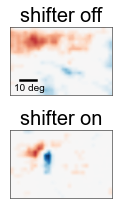

In [59]:
########## Fig 2D ########## 
# gs02 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs0[1:,5:],wspace=1,hspace=.5)
# gs02b = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs02[:2,:2],wspace=.1,hspace=.8)
# axs3 = np.array([fig1.add_subplot(gs02b[0,0]), fig1.add_subplot(gs02b[0,1]),fig1.add_subplot(gs02b[1,0]), fig1.add_subplot(gs02b[1,1])]).reshape(2,2)
fontsize=20
fig, axs3 = plt.subplots(2,1,figsize=(4,3))
lag = 1
da = 0
cells = [22]
for n, cell in enumerate(cells):
    ax = axs3[n]
    crange2 = np.max(np.abs(All_data[pparams['date_ani2'][da]][exp_type]['VisNoShifter_rf_up'][cell]))
    im2 = ax.imshow(All_data[pparams['date_ani2'][da]][exp_type]['VisNoShifter_rf_up'][cell,lag],'RdBu_r', vmin=-crange2, vmax=crange2)
    ax.set_title('shifter off',fontsize=fontsize)
    ax = axs3[n+1]
    crange2 = np.max(np.abs(All_data[pparams['date_ani2'][da]][exp_type]['Vis_rf_up'][cell,2]))
    im2 = ax.imshow(All_data[pparams['date_ani2'][da]][exp_type]['Vis_rf_up'][cell,2],'RdBu_r', vmin=-crange2, vmax=crange2)
    ax.set_title('shifter on',fontsize=fontsize)
scalebar = AnchoredSizeBar(axs3[0].transData,
                    20, '10 deg', 'lower left', 
                    pad=0.1,
                    color='black',
                    frameon=False,
                    size_vertical=1,
                    )
axs3[0].add_artist(scalebar)  
for ax in axs3.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
    
figname = paper_fig_dir/'Shifter_noshifter_RFs.pdf'
fig.savefig(figname,transparent=True, bbox_inches='tight')

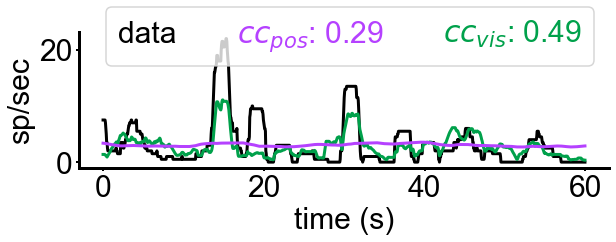

In [48]:
cell=265
fontsize=30
CellNum_Tot = get_cellnums(All_data,pparams,exp_type=exp_type)
da,celln = ([[da,np.where(CellNum_Tot[key]==cell)[0][0]] for da,key in enumerate(CellNum_Tot.keys()) if len(np.where(CellNum_Tot[key]==cell)[0])>0])[0]
########## Fig 4C/G ########## 
fig, axs = plt.subplots(1,1,figsize=(9.5,2.5))
cmap = mpl.colors.ListedColormap(q_clrs)

# celln = 49#52#106
# da = 3
mod_titles2 = ['pos','vis','add','mul','HF']

t = np.argmin(np.abs((np.arange(All_data[pparams['date_ani2'][da]]['actual_smooth'].shape[0])*params['model_dt'])-140)) # 200 seconds in #6000
dt = int(60/params['model_dt']) #All_data[pparams['date_ani2'][da]]['actual_smooth'].shape[0] # dt in seconds converted to time points
##### Plotting Firing Rate #####
pred_time = (np.arange(All_data[pparams['date_ani2'][da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
ax = axs
zorder = (np.argsort([All_data[pparams['date_ani2'][da]][exp_type][pparams['mod_titles'][modN]+'_cc_test'][celln] for modN in range(len(pparams['mod_titles'][:-1]))])+1)[::-1]
ax.plot(pred_time,All_data[pparams['date_ani2'][da]]['actual_smooth'][t:t+dt,celln],c='k',lw=3,label='data',zorder=0)
for modN in range(0,2):
    ax.plot(pred_time,All_data[pparams['date_ani2'][da]][exp_type][pparams['mod_titles'][modN]+'_pred_smooth'][t:t+dt,celln],c=mod_clrs[modN],lw=3,
            label=r'$cc_{{{}}}$: {:.02f}'.format(mod_titles2[modN],All_data[pparams['date_ani2'][da]][exp_type][pparams['mod_titles'][modN]+'_cc_test'][celln]),zorder=zorder[modN])
legend1 = ax.legend(labelcolor='linecolor', fontsize=fontsize, handlelength=0, handletextpad=0,loc='upper right',ncol=5, bbox_to_anchor=(1, 1.3))
# legend1.texts[1].set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),path_effects.Normal()])
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(3)
    
figname = paper_fig_dir/'VM_frtrace.pdf'
fig.savefig(figname,transparent=True, bbox_inches='tight')

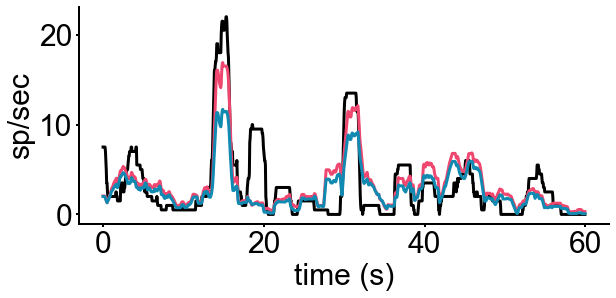

In [30]:
cell=265
fontsize=30
CellNum_Tot = get_cellnums(All_data,pparams,exp_type=exp_type)
da,celln = ([[da,np.where(CellNum_Tot[key]==cell)[0][0]] for da,key in enumerate(CellNum_Tot.keys()) if len(np.where(CellNum_Tot[key]==cell)[0])>0])[0]
########## Fig 4C/G ########## 
fig, axs = plt.subplots(1,1,figsize=(9.5,4))
cmap = mpl.colors.ListedColormap(q_clrs)

# celln = 49#52#106
# da = 3
mod_titles2 = ['pos','vis','add','mul','HF']

t = np.argmin(np.abs((np.arange(All_data[pparams['date_ani2'][da]]['actual_smooth'].shape[0])*params['model_dt'])-140)) # 200 seconds in #6000
dt = int(60/params['model_dt']) #All_data[pparams['date_ani2'][da]]['actual_smooth'].shape[0] # dt in seconds converted to time points
##### Plotting Firing Rate #####
pred_time = (np.arange(All_data[pparams['date_ani2'][da]]['actual_smooth'].shape[0])*params['model_dt'])[0:np.abs(dt)]
ax = axs
zorder = (np.argsort([All_data[pparams['date_ani2'][da]][exp_type][pparams['mod_titles'][modN]+'_cc_test'][celln] for modN in range(len(pparams['mod_titles'][:-1]))])+1)[::-1]
ax.plot(pred_time,All_data[pparams['date_ani2'][da]]['actual_smooth'][t:t+dt,celln],c='k',lw=3,label='data',zorder=0)
for modN in range(2,len(pparams['mod_titles'])-2):
    ax.plot(pred_time,All_data[pparams['date_ani2'][da]][exp_type][pparams['mod_titles'][modN]+'_pred_smooth'][t:t+dt,celln],c=mod_clrs[modN],lw=3,
            label=r' $cc_{{{}}}$: {:.02f}'.format(mod_titles2[modN],All_data[pparams['date_ani2'][da]][exp_type][pparams['mod_titles'][modN]+'_cc_test'][celln]),zorder=zorder[modN])
# ax.legend(labelcolor='linecolor', fontsize=fontsize, handlelength=0, handletextpad=0,loc='upper right',ncol=5, bbox_to_anchor=(1, .8))
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel('sp/sec',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(3)

paper_fig_dir = Path('/home/seuss/Dropbox (University of Oregon)/Presentations/SFN_2022')
paper_fig_dir
figname = paper_fig_dir/'AM_frtrace.pdf'
fig.savefig(figname,transparent=True, bbox_inches='tight')

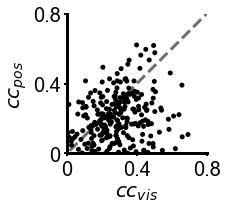

In [63]:
fig, axs = plt.subplots(figsize=(3.2,3.2))
########## Fig 4D ########## 
fr_th = 1 # hz
vals_Mot = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mot_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Vis = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Add = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Add_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Mul = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mul_cc_test'] for da in range(len(pparams['dates_all']))])


lims = (-.05, .85)
ticks = [0,.4,.8]
ln_max = .8
crange=500
##### Vis vs Mot #####
ax = axs
im=ax.scatter(vals_Vis,vals_Mot,c='k',s=25,edgecolors='none')
ax.plot(np.linspace(lims[0],ln_max),np.linspace(lims[0],ln_max),c='#6D6E71',ls='--',zorder=0,lw=3)
ax.set_xlabel(r'$cc_{vis}$',fontsize=fontsize)
ax.set_ylabel(r'$cc_{pos}$',fontsize=fontsize)
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)
ax.axis('square')
ax.set_ylim(0,.8)
ax.set_xlim(0,.8)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(3)
plt.tight_layout()
figname = paper_fig_dir/'VM_Scatter.pdf'
fig.savefig(figname,transparent=True, bbox_inches='tight')

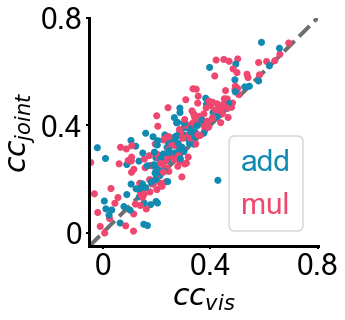

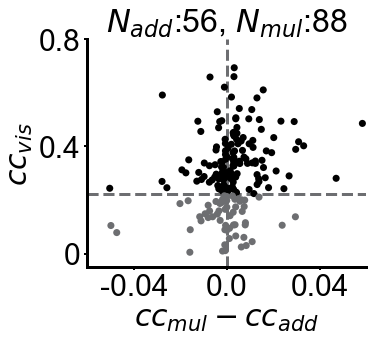

In [42]:
fig, axs =plt.subplots(figsize=(5,4.2))
fr_th = 1 # hz
vals_Mot = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mot_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Vis = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Vis_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Add = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Add_cc_test'] for da in range(len(pparams['dates_all']))])
vals_Mul = np.hstack([All_data[pparams['date_ani2'][da]][exp_type]['Mul_cc_test'] for da in range(len(pparams['dates_all']))])

lims = (-.05, .85)
ticks = [0,.4,.8]
ln_max = .8

##### Vis vs Add/Mul #####
cmap_mod = mpl.colors.ListedColormap(mod_clrs[2:4])
vals_AM = np.nanmax(np.stack((vals_Add,vals_Mul)),axis=0)
AvM = vals_Add<vals_Mul
AvM_thresh = (~np.isnan(vals_Vis)) & (~np.isnan(vals_AM))
ax = axs
scatter=ax.scatter(vals_Vis[AvM_thresh],vals_AM[AvM_thresh],s=50,c=AvM[AvM_thresh],cmap=cmap_mod,edgecolors='none')
ax.plot(np.linspace(lims[0],ln_max),np.linspace(lims[0],ln_max),c='#6D6E71',ls='--',zorder=0,lw=4)
ax.set_xlabel(r'$cc_{vis}$',fontsize=fontsize)
ax.set_ylabel(r'$cc_{joint}$',fontsize=fontsize)
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)
ax.axis('square')
ax.set_ylim(-.05, .8)
ax.set_xlim(-.05, .8)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),fontsize=fontsize,markerscale=0, handlelength=0, handletextpad=0,loc="lower right")
legend1.get_texts()[0].set_text('add')
legend1.get_texts()[0].set_color(mod_clrs[2])
legend1.get_texts()[1].set_text('mul')
legend1.get_texts()[1].set_color(mod_clrs[3])
ax.tick_params(axis='both', which='major', labelsize=fontsize)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(3)
figname = paper_fig_dir/'VisAddMul_Scatter.pdf'
fig.savefig(figname,transparent=True, bbox_inches='tight')

move_r2_th = ((vals_Add>vals_Vis) | (vals_Mul>vals_Vis)) # (vals_Mot>.05) & (vals_Vis>.05) &
vals_Mot = vals_Mot[move_r2_th]
vals_Vis = vals_Vis[move_r2_th]
vals_Add = vals_Add[move_r2_th]
vals_Mul = vals_Mul[move_r2_th]
# celltypes_all2 = celltypes_all[:,move_r2_th]

fig,axs = plt.subplots(figsize=(5,4.2))
##### R2 Explained Variance V2 #####
diff = vals_Mul-vals_Add
increase = vals_Vis
th1 = ((increase>0) & (vals_Vis>.22))
th2 = ((increase>0) & (vals_Vis<.22))

NMul = np.sum(((diff[th1]>0)&(vals_Vis[th1]>.22)))
NAdd = np.sum(((diff[th1]<0)&(vals_Vis[th1]>.22)))
ax=axs
im = ax.scatter(diff[th1],increase[th1],s=50,c='k',edgecolors='none')
im = ax.scatter(diff[th2],increase[th2],s=50,c='#6D6E71',edgecolors='none')
# im = ax.scatter(diff[th],increase[th],c=celltypes_all2[1,th],cmap='jet',s=20,vmin=-500,vmax=500)
ax.axvline(x=0,c='#6D6E71',ls='--',zorder=0,lw=3)
ax.set_ylabel(r'$cc_{vis}$',fontsize=fontsize)
ax.set_xlabel(r'$cc_{mul}-cc_{add}$',fontsize=fontsize)
ax.set_title(r'$N_{{add}}$:{}, $N_{{mul}}$:{}'.format(NAdd,NMul),fontsize=fontsize+2)
ax.set_ylim(-.05,.8)
ax.set_xlim(-.06,.06)
ax.set_xticks([-.04, 0, .04])
ax.set_xticklabels(np.round([-.04,0,.04],decimals=2))
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
ax.axhline(y=np.sqrt(.05),color='#6D6E71',ls='--',zorder=0,lw=3)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(3)
figname = paper_fig_dir/'AddMul_Scatter.pdf'
fig.savefig(figname,transparent=True, bbox_inches='tight')
